# Forecasting EV Charging Demand in Palo Alto (USA), Dundee (UK) and Perth (AUS) with Random Forest Regressor

## Table of Contents
* [1. Introduction](#chapter1)
* [2. Feature Engineering](#chapter1)
* [3. Random Forest Forecasting for Palo Alto](#chapter2)
    * [3.1 Basic stats](#chapter2.1)
    * [3.2 Model Implementation](#chapter2.1)
* [4. Random Forest Forecasting for Dundee](##chapter3)
    * [4.1 Basic stats](##chapter3.1)
    * [4.2 Model Implementation](##chapter3.2)
* [5. Random Forest Forecasting for Perth](#chapter4)
    * [5.1 Basic stats](#chapter4.1)
    * [5.2 Model Implementation](#chapter4.2)
* [6. Conclusion](#chapter6)

## 1. Introduction

This notebook details the implementation and exploration of a Random Forest Regressor model to forecast the demand for Electric Vehicle (EV) charging stations in Palo Alto (USA), Dundee (UK), and Perth (AUS). The focus is on analyzing and forecasting the demand for EV charging facilities, a crucial aspect of urban and transport planning in the era of increasing electric vehicle adoption. Accurate demand forecasts are vital for infrastructure development, optimizing energy consumption, and enhancing user satisfaction. That can be achieved by developing and refining a Random Forest Regressor model that predicts the future demand for EV charging stations in the specified cities. By leveraging historical data and various predictor variables, the model aims to provide reliable forecasts that can assist stakeholders in making informed decisions.
Before implementing the Random Forest Regressor it is important to have an overview of which stations are being observed, do they have enough data, are there any duplicates or missing values, which will be implemented in the next section. The performance of the Random Forest Regressor will be evaluated through RMSE (Root Mean Squared Error).

# 2. Feature Engineering

All three datasets are of similar structure, with many features having constant naming. However, there is a small difference in variable naming across different datasets. The features that will be used in this analysis are:

For Palo Alto:
- **Station Name**: the name of the charging station, together with plugin number
- **Start Date**: date and time when EV charging started
- **End Date**: date and time when EV charging started ended
- **Energy (kWh)**: amount of energy consumed per EV charged

For Dundee:
- **Address 1**: Adress of the charging station
- **Start Date**: date and time when EV charging started
- **End Date**: date and time when EV charging started ended
- **Energy (kWh)**: amount of energy consumed per EV charged

For Perth:
- **Site**: the name of the charging station
- **Start Date**: date and time when EV charging started
- **End Date**: date and time when EV charging started ended
- **Total kWh**: amount of energy consumed per EV charged

The target variable for this analysis will be **Energy (kWh)**. The input variable is simply the lagged target variable (**Energy (kWh)**). The following code snippet creates function **buildLaggedFeatures**, which will be called when initializing number of lags for making predictions for all three datasets.

In [11]:
import pandas as pd

""" 
Use this when using better adjustment control snippet code below
#Specify the days in one lag -----------------------------
lag_num= 30
#---------------------------------------------------------
# Function to create lagged features """


def buildLaggedFeatures(s, lag, dropna=True):
    df = pd.concat([s.shift(i) for i in range(lag + 1)], axis=1)
    df.columns = ['lag_{}'.format(i) if i != 0 else s.name for i in range(lag + 1)]
    if dropna:
        df = df.dropna()
    return df

## 3. Random Forest Forecasting for Palo Alto

In [12]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
from fpdf import FPDF
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
warnings.filterwarnings("ignore")

data = pd.read_csv('EVChargingStationUsage.csv')

After importing necessary packages and loading data, the first step is to get overfiew of different stations, and more importantly do they have enough observations for conducting a forecast.

### 3.1 Basic Stats

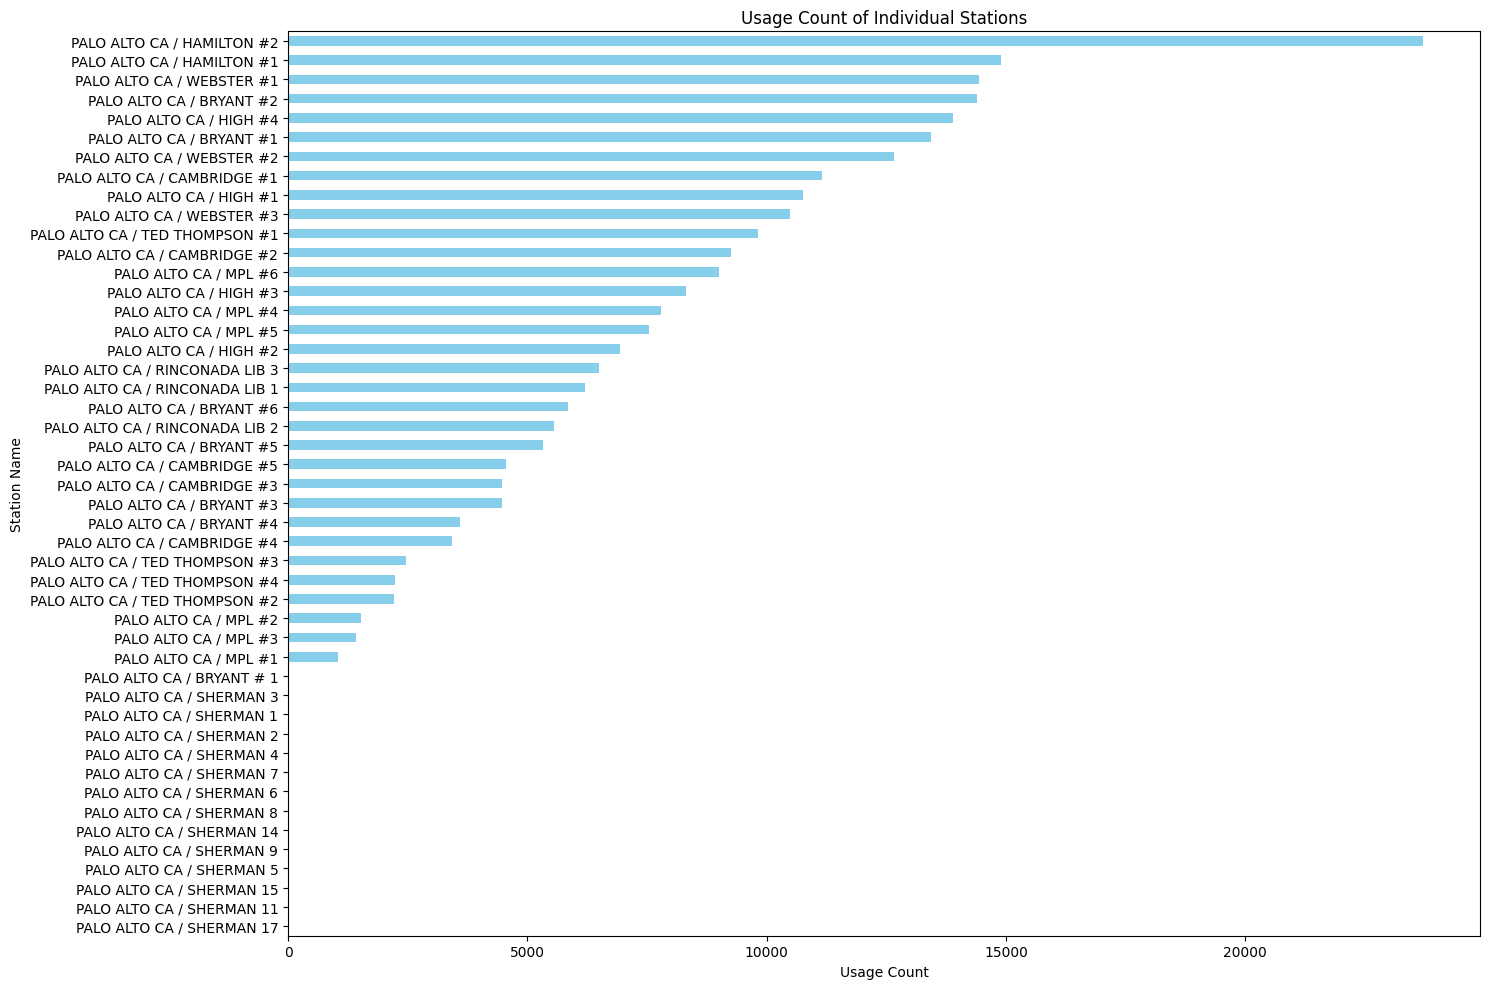

In [13]:
#occurrences of each unique station
station_counts = data['Station Name'].value_counts()
plt.figure(figsize=(15, 10))  
station_counts.plot(kind='barh', color='skyblue')  
plt.title('Usage Count of Individual Stations')
plt.xlabel('Usage Count')
plt.ylabel('Station Name')
plt.gca().invert_yaxis()  
plt.tight_layout()  
plt.show()

It is visible that all stations contain # int, representing the number of inputs/plugins in selected charging stations. The next step is then to merge the stations with the same name, but different # int into one entity. That will make further analysis more useful for the provider companies, as it's more important to get the energy demand of the whole station than just one input/plugin.   

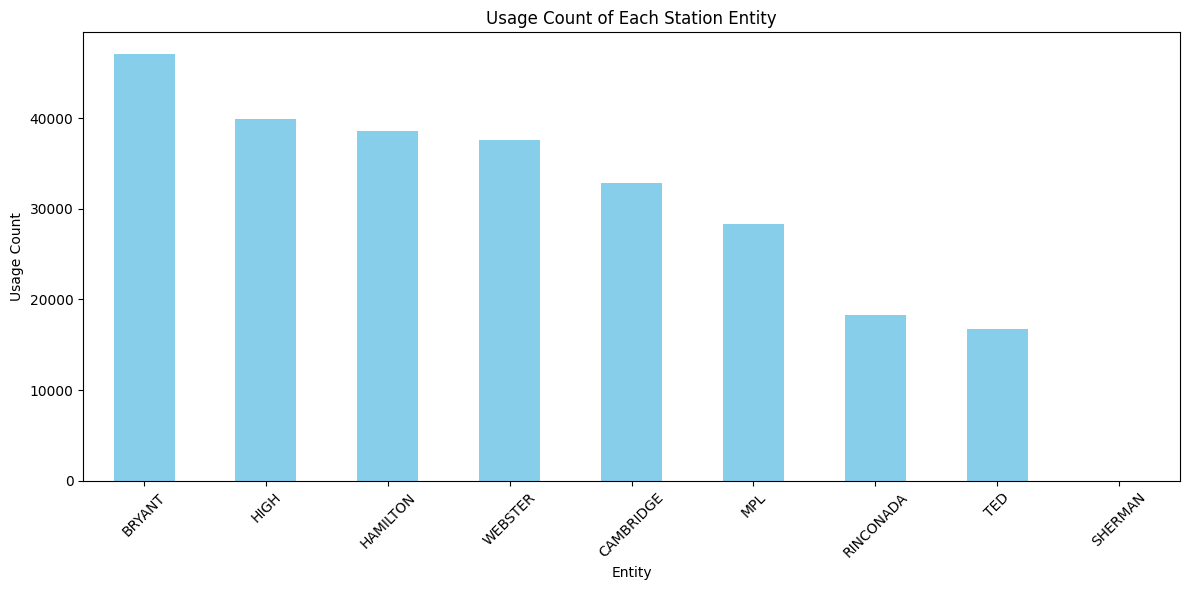

In [14]:
#function to extract the entity based on the first word following "PALO ALTO CA /"
def extract_entity(station_name):
    parts = station_name.split('/')
    if len(parts) > 1:
        # Take the part after "PALO ALTO CA /" and then take the first word
        return parts[1].strip().split(' ')[0]
    else:
        # If the station name does not follow the expected format, return the original
        return station_name

#function to create the 'Entity' column
data['Entity'] = data['Station Name'].apply(extract_entity)
#occurrences of each entity
entity_counts = data['Entity'].value_counts()

#plotting the usage count of each entity
plt.figure(figsize=(12, 6))
entity_counts.plot(kind='bar', color='skyblue')
plt.title('Usage Count of Each Station Entity')
plt.xlabel('Entity')
plt.ylabel('Usage Count')
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

From the plot above, it can be observed that Sherman Station has no observations, and therefore will not be considered in the further analysis. 

### 3.2 Model Implementation

In this section, the forecasting be implemented for the following time windows:
- 1 day
- 7 days
- 30 days

For 7 days time frame, we will reorganize the observations structure, so that sum the of the energy demand of 7 days will be one observation. Similarly, sum the of the energy demand of 30 days will be considered as one observation for 30 days time frame. For 1 and 7 day time frame, 30 lags are created, and for 30 day time frame we'll initialize 7 lags. 

Additonally the RF predictions will be used as input for the LLM model consturcted in further sections in this work. Thus, a pdf file, in which the daily, weekly and monthly prediciotns for all charging stations in Palo Alto city will be created.


In [15]:
# Prepare PDF
pdf_path = "papers\Station_Predictions.pdf"
c = canvas.Canvas(pdf_path, pagesize=letter)
c.setTitle("Station Predictions")
width, height = letter  # Get dimensions of the page

# Text offset
y_position = height - 40

# Header
c.setFont("Helvetica-Bold", 16)
c.drawString(30, y_position, "EV Charging Station Predictions for the next day, month and week for all our charging stations in the city of Palo Alto ")
c.setFont("Helvetica", 12)
y_position -= 20

def draw_text(text, x, y):
    text_width = c.stringWidth(text, "Helvetica", 12)
    if text_width <= width - 60:
        c.drawString(x, y, text)
    else:
        words = text.split()
        new_line = ""
        for word in words:
            line_width = c.stringWidth(new_line + word + " ", "Helvetica", 12)
            if line_width < width - 60:
                new_line += word + " "
            else:
                c.drawString(x, y, new_line)
                y -= 20
                new_line = word + " "
        c.drawString(x, y, new_line)
    return y

**Daily predictions**

RMSE for PALO ALTO CA / HAMILTON Stations: 32.46222694458618
RMSE for PALO ALTO CA / HIGH Stations: 36.16941561545822
RMSE for PALO ALTO CA / BRYANT Stations: 33.903140581096466
RMSE for PALO ALTO CA / MPL Stations: 34.53773515963822
RMSE for RINCONADA LIB Stations: 39.53015181005031
RMSE for PALO ALTO CA / WEBSTER Stations: 43.40433368866264
RMSE for PALO ALTO CA / TED THOMPSON Stations: 31.041726647661154
RMSE for PALO ALTO CA / CAMBRIDGE Stations: 55.94361926734477


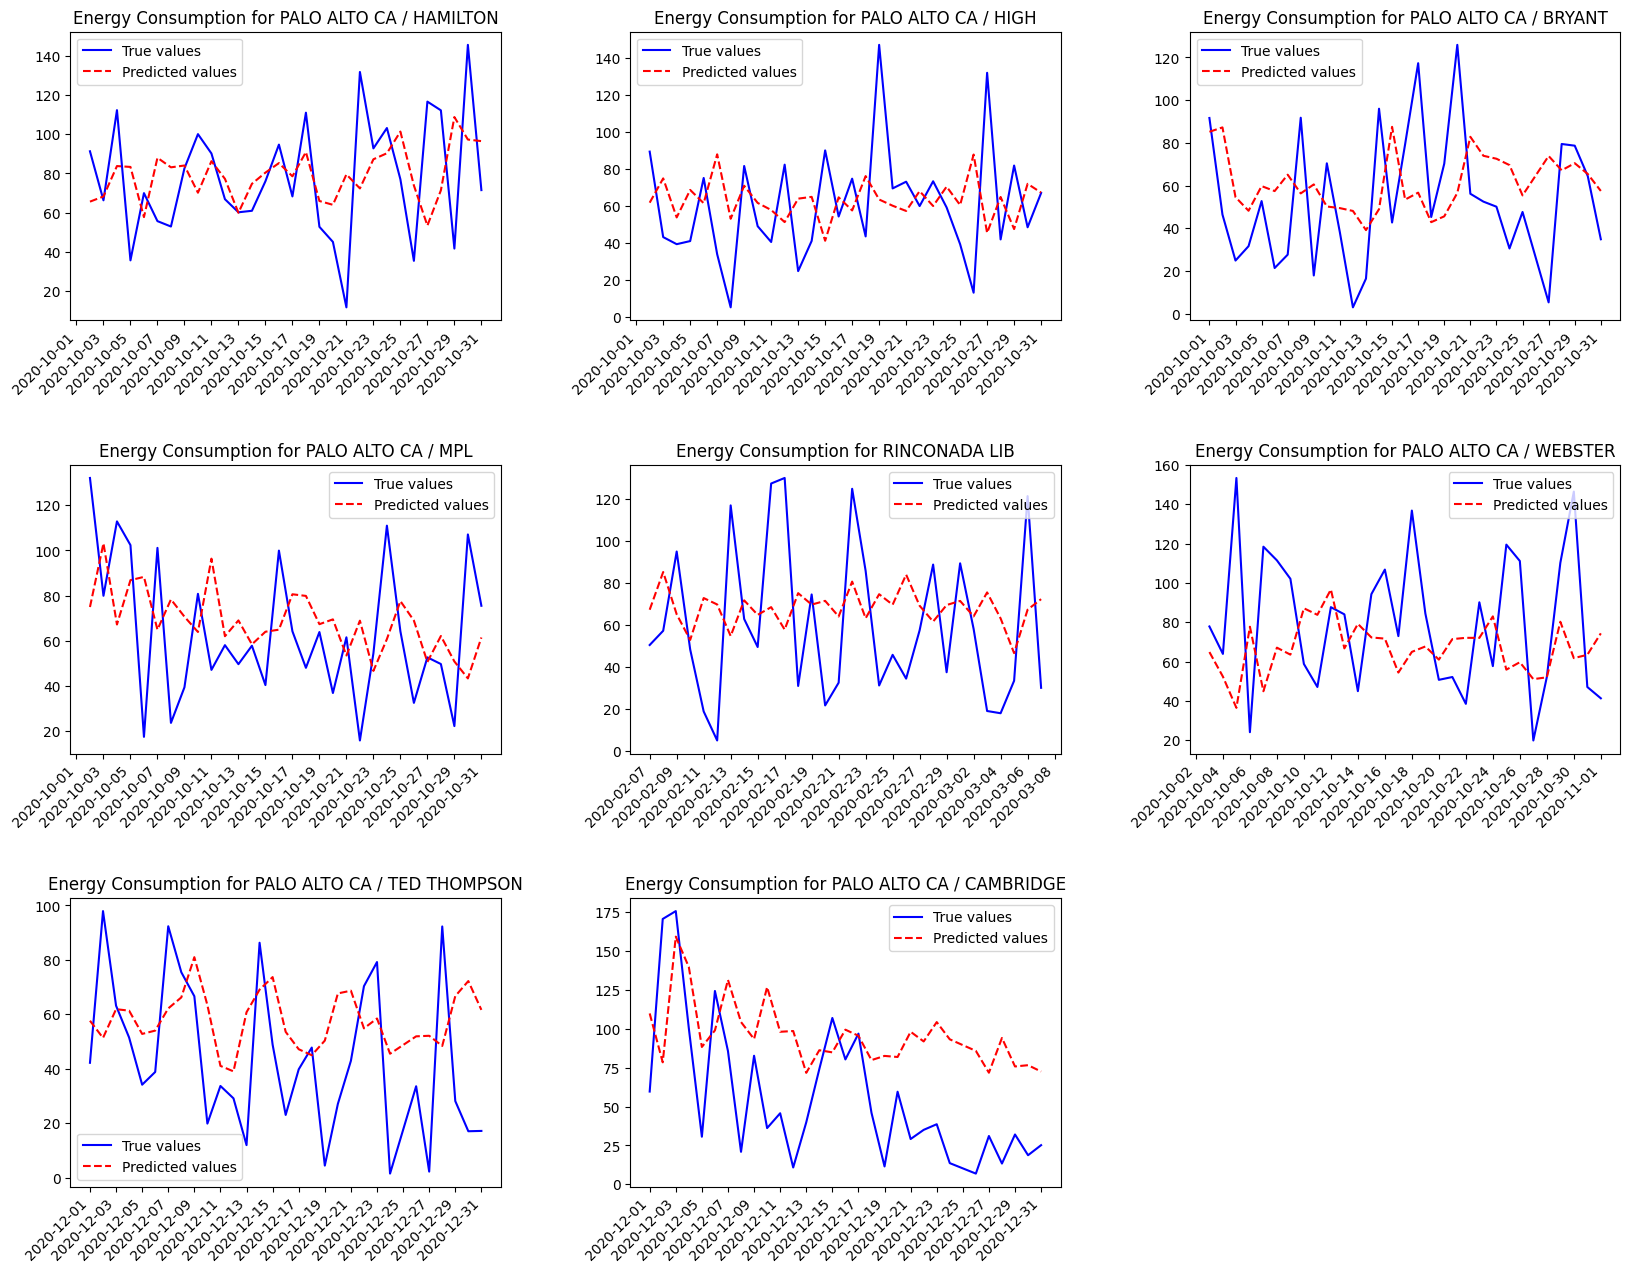

In [16]:
# Normalize station names
def normalize_station_name(name):
    name = name.upper()
    if "RINCONADA" in name:
        parts = name.split()
        new_parts = []
        for part in parts:
            if part.startswith('LIB') and len(parts) > parts.index(part) + 1 and parts[parts.index(part) + 1].isdigit():
                digit = parts.pop(parts.index(part) + 1)
                new_parts.append(part + ' #' + digit)
            else:
                new_parts.append(part)
        modified_name = ' '.join(new_parts)
        if 'RINCONADA LIB #' in modified_name:
            return 'RINCONADA LIB'
        return modified_name
    if "SHERMAN" in name:
        return None
    return name.split('#')[0].strip()

data['Normalized Station Name'] = data['Station Name'].apply(normalize_station_name)
data = data.dropna(subset=['Normalized Station Name'])

stations = data['Normalized Station Name'].unique()

# Set up the plot grid
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
axes = axes.flatten()
fig.subplots_adjust(hspace=0.5, wspace=0.3)

#Initialize empty dict
daily_predictions_dict={}
for station in stations:
    daily_predictions_dict[station]={'y_test':[], 'y_pred':[], 'rmse':0}
    
# Processing each normalized station group
for idx, station in enumerate(stations):
    if idx >= 9:
        break
    station_data = data[data['Normalized Station Name'] == station]
    station_data['Start DateTime'] = pd.to_datetime(station_data['Start Date'] + ' ' + station_data['Start Time Zone'], errors='coerce')
    station_data.dropna(subset=['Start DateTime'], inplace=True)
    daily_energy = station_data.groupby(station_data['Start DateTime'].dt.floor('D'))['Energy (kWh)'].sum()
    lagged_features = buildLaggedFeatures(daily_energy, lag=30)
    train_data = lagged_features.iloc[:-30] 
    test_data = lagged_features.iloc[-30:] 
    X_train = train_data.drop(columns=['Energy (kWh)'])
    y_train = train_data['Energy (kWh)']
    X_test = test_data.drop(columns=['Energy (kWh)'])
    y_test = test_data['Energy (kWh)']
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor.fit(X_train, y_train)
    y_pred = rf_regressor.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE for {station} Stations: {rmse}')
    ax = axes[idx]
    ax.plot(y_test.index, y_test, color='blue', label='True values')
    ax.plot(y_test.index, y_pred, color='red', linestyle='--', label='Predicted values')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))  # Set interval to 2 for every second day
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")
    ax.set_title(f'Energy Consumption for {station}')
    ax.legend()
    daily_predictions_dict[station]={'y_test':[y_test], 'y_pred':[y_pred], 'rmse':rmse}
    # Write station data to PDF
    info_text = f"City: {station} - Station: {station} - Last Day Prediction: {y_pred[0]:.2f} kWh - Error: {rmse:.2f} - Time Window: 1 day"
    y_position = draw_text(info_text, 30, y_position)
    y_position -= 20  # Move to the next line
    if y_position < 40:
        c.showPage()
        y_position = height - 40
        
file_path = 'daily_predictions_palo_alto_rf.pk1'
with open(file_path, 'wb') as file:
    pickle.dump(daily_predictions_dict, file)

# Hide any unused axes if there are less than 9 stations
for ax in axes[len(stations):]:
    ax.set_visible(False)
    


plt.show()

**Weekly predictions**

RMSE for PALO ALTO CA / HAMILTON Stations: 99.1458134707777
RMSE for PALO ALTO CA / HIGH Stations: 162.19340061016558
RMSE for PALO ALTO CA / BRYANT Stations: 134.50417454957304
RMSE for PALO ALTO CA / MPL Stations: 159.3302296641382
RMSE for RINCONADA LIB Stations: 126.41696466282528
RMSE for PALO ALTO CA / WEBSTER Stations: 194.76359504704436
RMSE for PALO ALTO CA / CAMBRIDGE Stations: 152.8454115027766
RMSE for PALO ALTO CA / TED THOMPSON Stations: 81.99870927339326


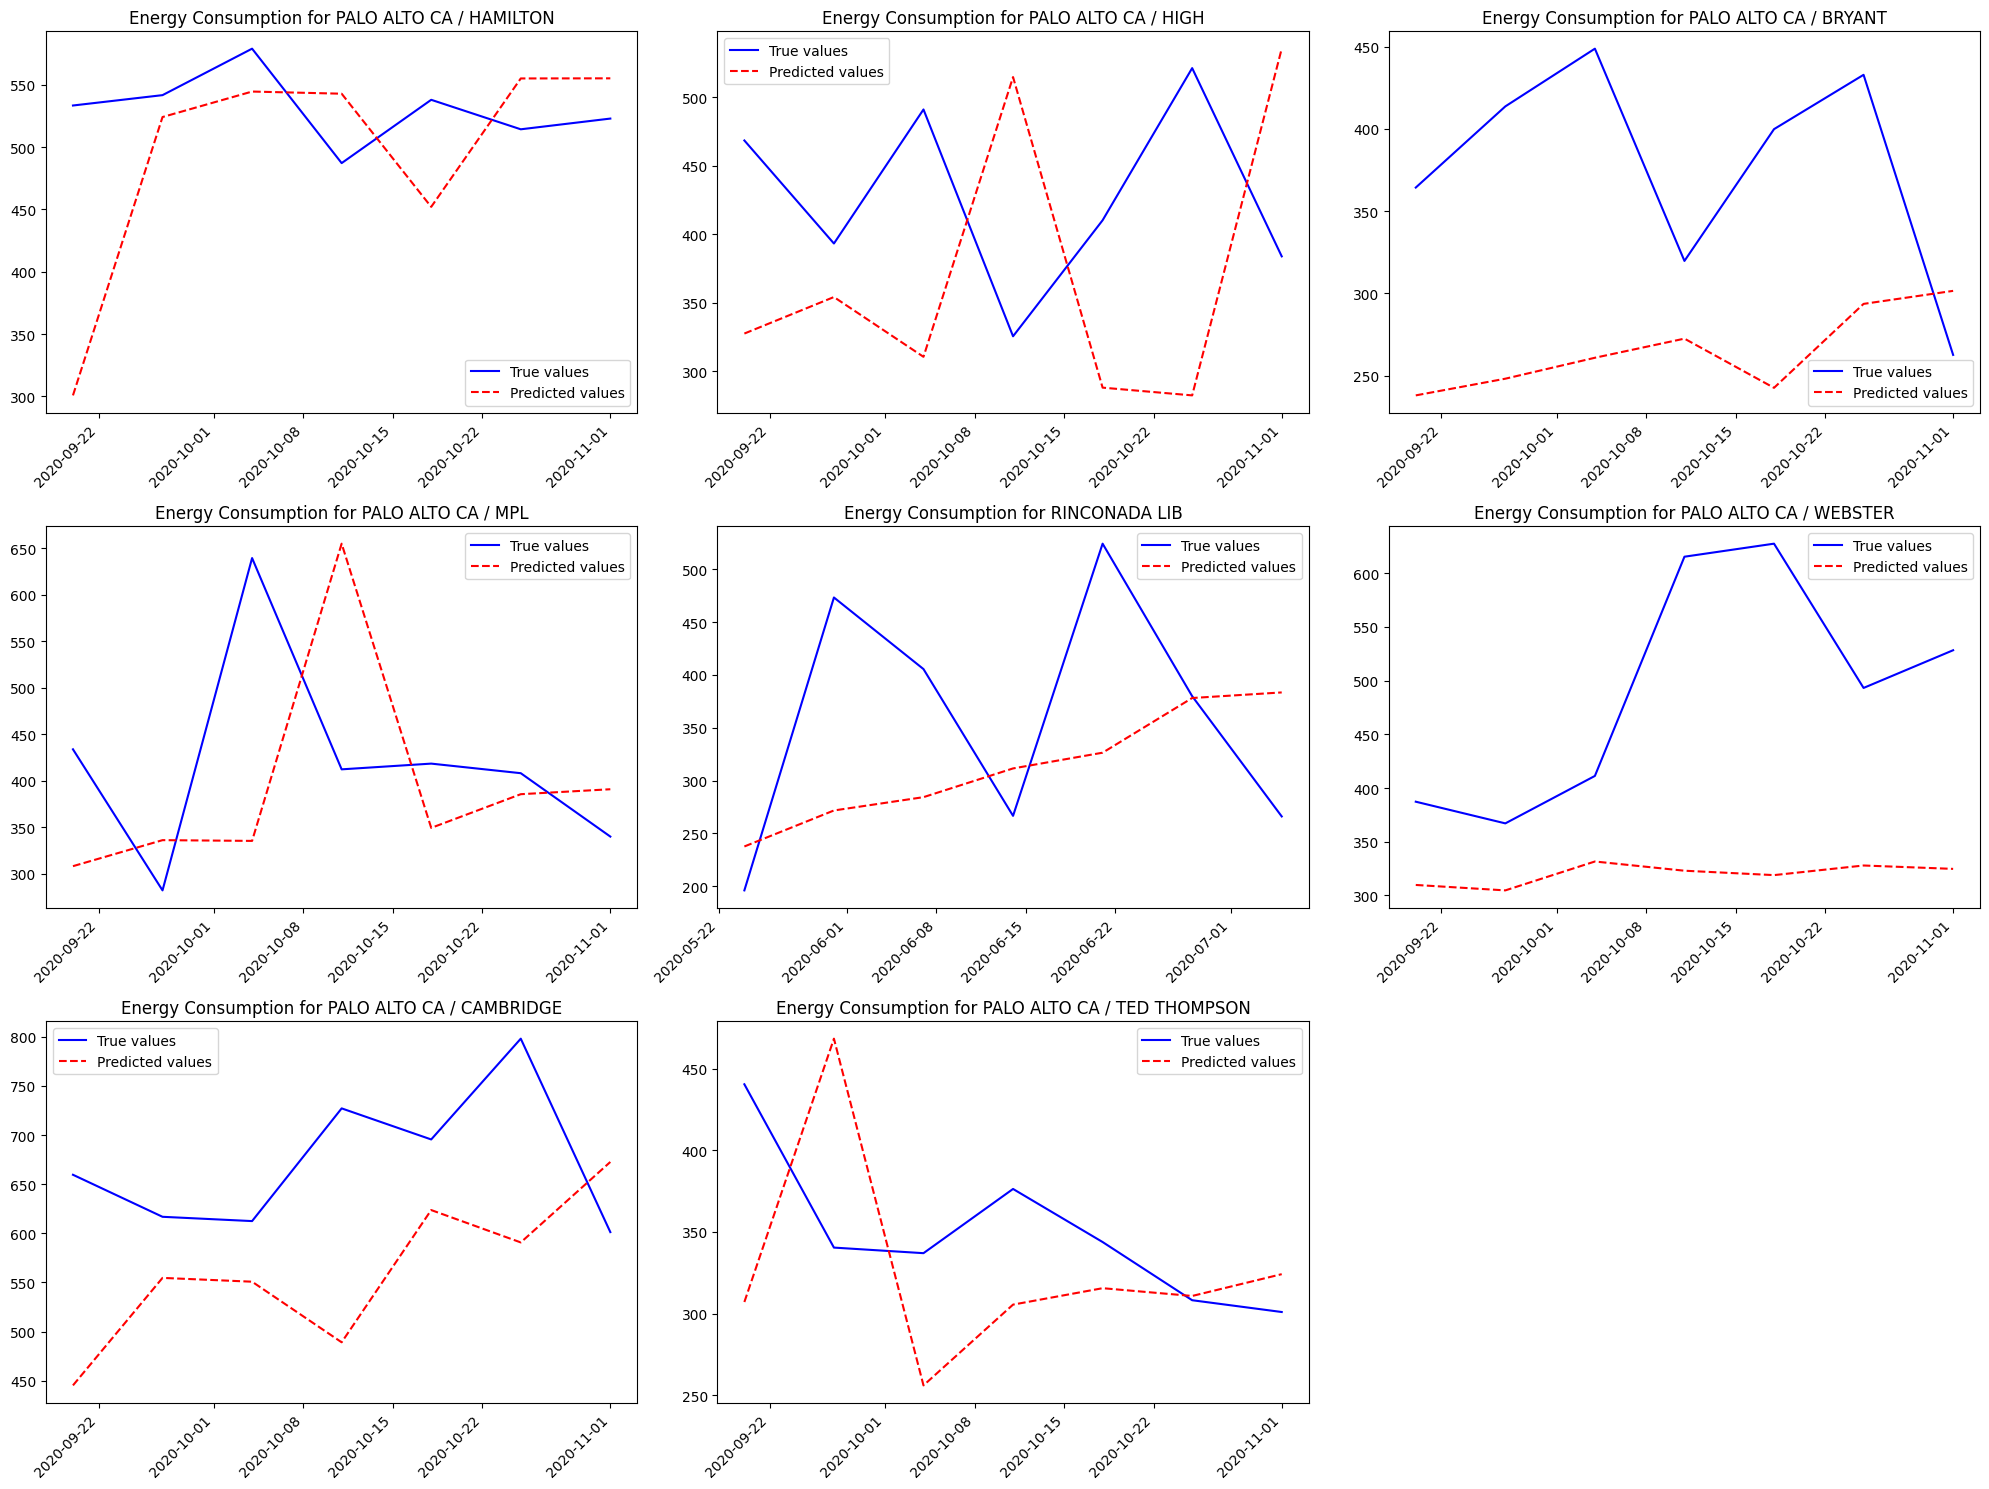

In [17]:
#data is reloaded as it needs to be preproccesed differently for different time windows
data = pd.read_csv('EVChargingStationUsage.csv')

data['Normalized Station Name'] = data['Station Name'].apply(normalize_station_name)
data['Start DateTime'] = pd.to_datetime(data['Start Date'] + ' ' + data['Start Time Zone'], errors='coerce')
data.dropna(subset=['Start DateTime'], inplace=True)

# Ensure 'Energy (kWh)' is a numeric column
data['Energy (kWh)'] = pd.to_numeric(data['Energy (kWh)'], errors='coerce')

# Determine the number of unique stations
num_stations = len(data['Normalized Station Name'].unique())

# Define the number of rows and columns for subplots
num_rows = (num_stations // 3) + (1 if num_stations % 3 != 0 else 0)
num_cols = min(num_stations, 3)

# Create subplots with dynamically determined size
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 5*num_rows))
axes = axes.flatten()
idx = 0

#Initialize empty dict
weekly_predictions_palo_alto_rf={}
for station in stations:
    weekly_predictions_palo_alto_rf[station]={'y_test':[], 'y_pred':[], 'rmse':0}

for station in data['Normalized Station Name'].unique():
    # Filter data for each station and then resample weekly
    station_data = data[data['Normalized Station Name'] == station]
    weekly_energy = station_data.set_index('Start DateTime').resample('W')['Energy (kWh)'].sum().dropna()

    if len(weekly_energy) < 10:  # Skip stations with less than 10 weeks of data
        continue

    lagged_features = buildLaggedFeatures(weekly_energy, lag=30)
    train_data = lagged_features.iloc[:-7]  # all data except last 7 weeks
    test_data = lagged_features.iloc[-7:]  # last 7 weeks

    X_train = train_data.drop(columns=[weekly_energy.name])
    y_train = train_data[weekly_energy.name]
    X_test = test_data.drop(columns=[weekly_energy.name])
    y_test = test_data[weekly_energy.name]

    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor.fit(X_train, y_train)
    y_pred = rf_regressor.predict(X_test)

    # RMSE
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE for {station} Stations: {rmse}')

    # Plotting
    ax = axes[idx]
    ax.plot(y_test.index, y_test, color='blue', label='True values')
    ax.plot(y_test.index, y_pred, color='red', linestyle='--', label='Predicted values')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")
    ax.set_title(f'Energy Consumption for {station}')
    ax.legend()
    idx += 1
    weekly_predictions_palo_alto_rf[station]={'y_test':[y_test], 'y_pred':[y_pred], 'rmse':rmse}
    # Write station data to PDF
    info_text = f"City: {station} - Station: {station} - Last Week Prediction: {y_pred[0]:.2f} kWh - Error: {rmse:.2f} - Time Window: 1 week"
    y_position = draw_text(info_text, 30, y_position)
    y_position -= 20  # Move to the next line
    if y_position < 40:
        c.showPage()
        y_position = height - 40
        
file_path = 'weekly_predictions_palo_alto_rf.pk1'
with open(file_path, 'wb') as file:
    pickle.dump(daily_predictions_dict, file)
    
# Hide any unused axes if there are less than num_stations
for ax in axes[idx:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

**Monthly predictions**

RMSE for PALO ALTO CA / HAMILTON Stations: 229.59200609908606
RMSE for PALO ALTO CA / HIGH Stations: 502.1305470431723
RMSE for PALO ALTO CA / BRYANT Stations: 332.0726500118526
RMSE for PALO ALTO CA / MPL Stations: 582.4904565621024
RMSE for RINCONADA LIB Stations: 761.3917580840841
RMSE for PALO ALTO CA / WEBSTER Stations: 1101.0940888629364
RMSE for PALO ALTO CA / CAMBRIDGE Stations: 590.024868805939
RMSE for PALO ALTO CA / TED THOMPSON Stations: 299.7190555153213


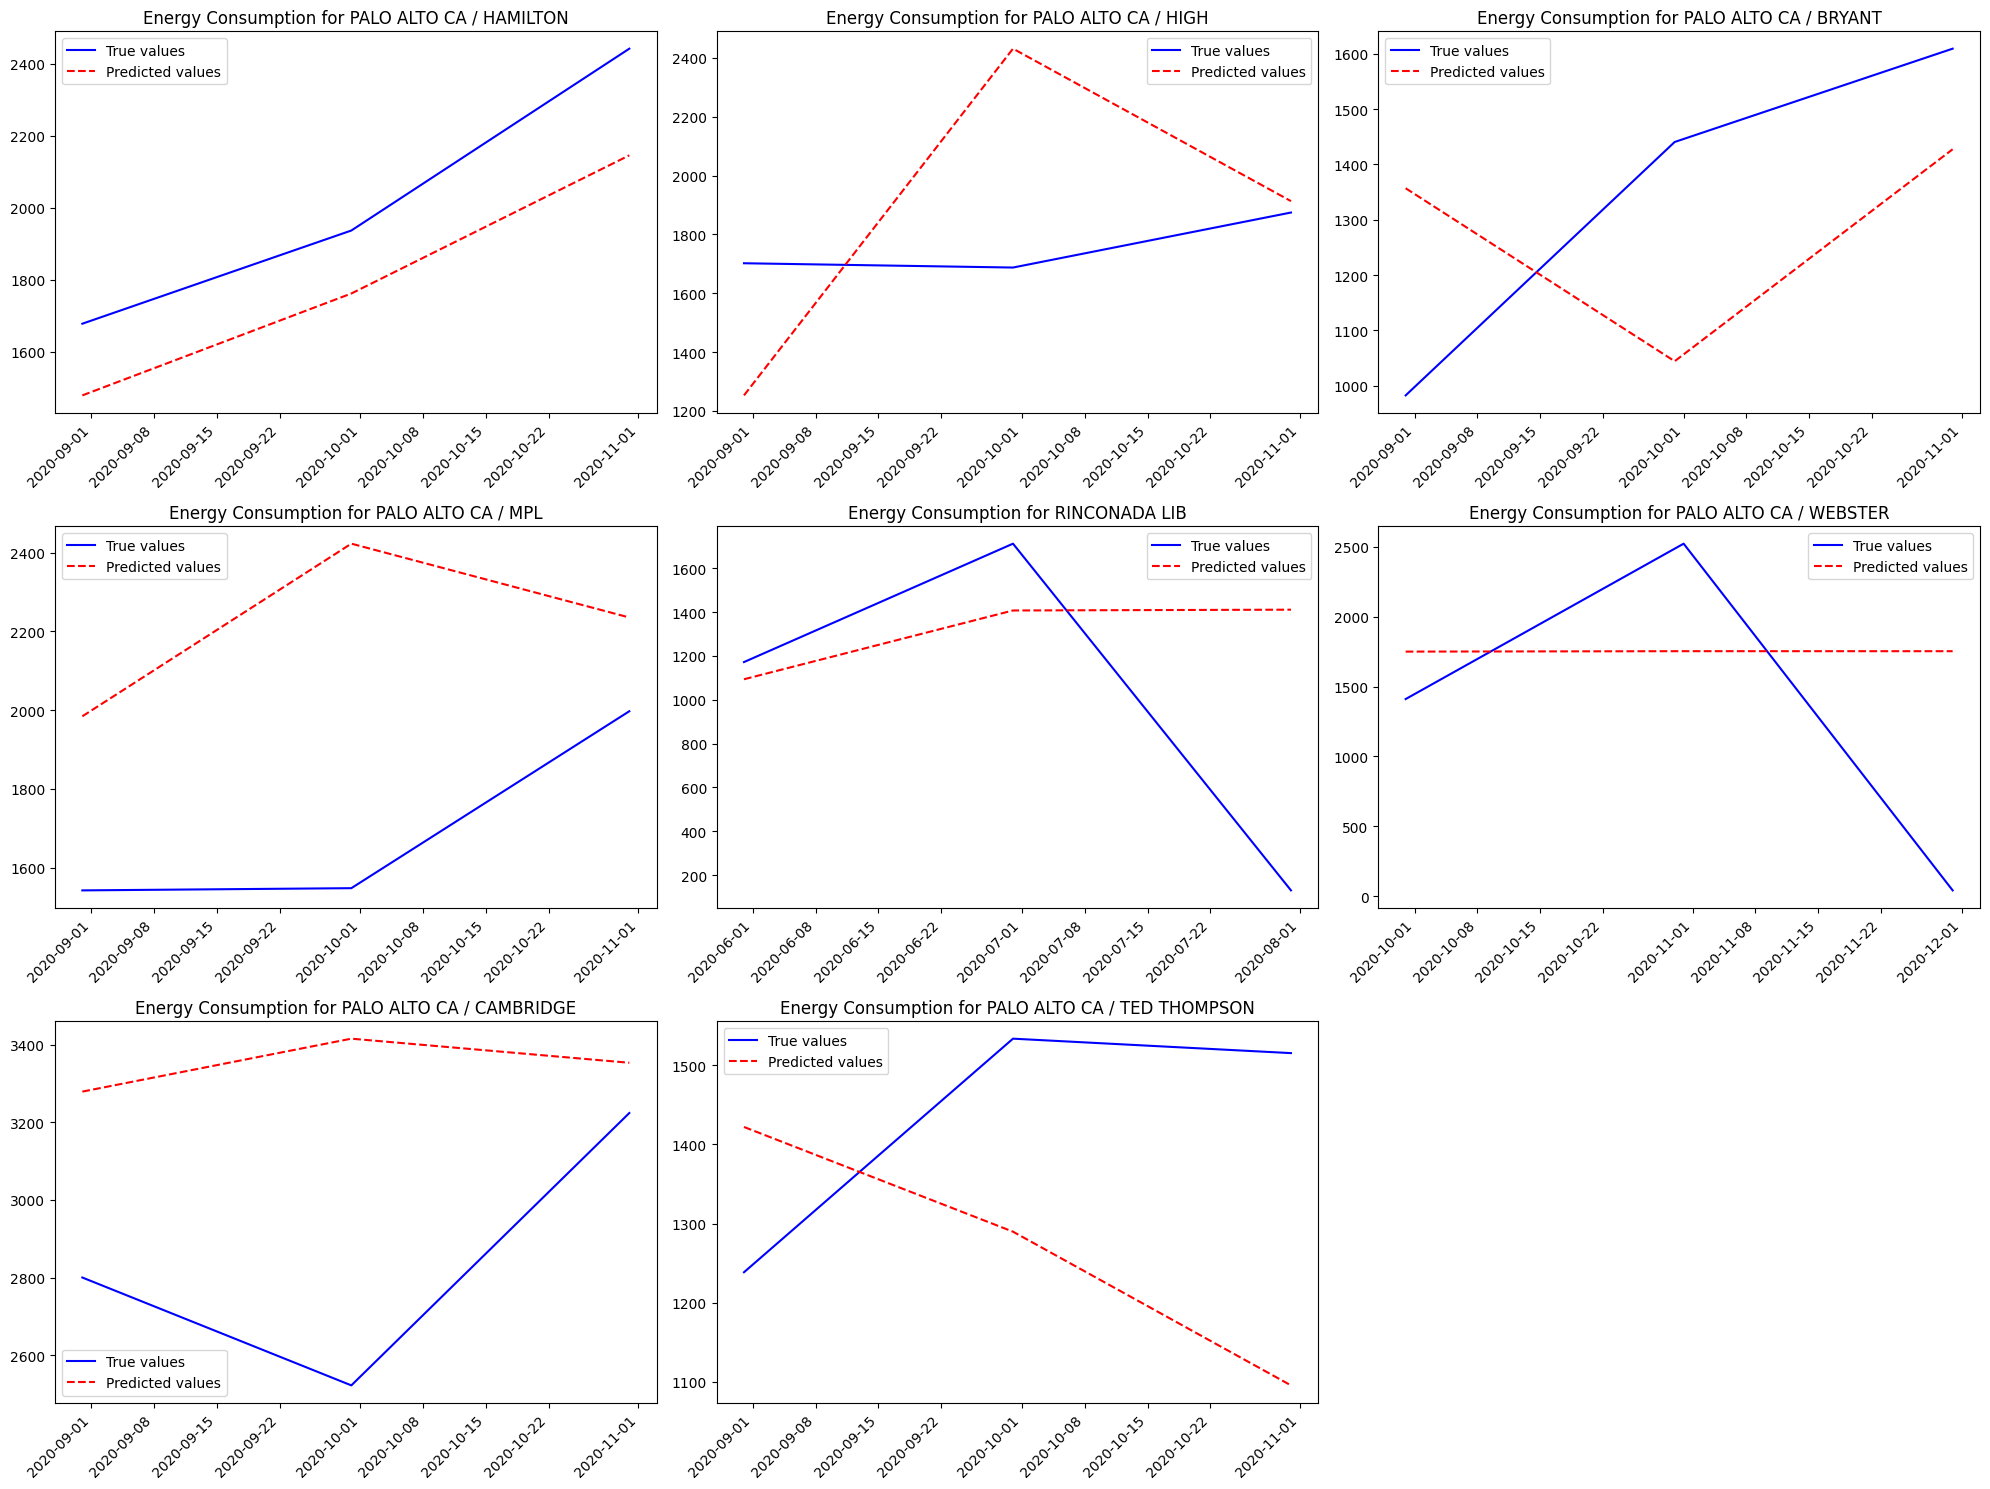

In [18]:
#data is reloaded as it needs to be preproccesed differently for different time windows
data = pd.read_csv('EVChargingStationUsage.csv')

# Ensure 'Energy (kWh)' is a numeric column
data['Energy (kWh)'] = pd.to_numeric(data['Energy (kWh)'], errors='coerce')

# Random forest model and plotting
data['Normalized Station Name'] = data['Station Name'].apply(normalize_station_name)
data['Start DateTime'] = pd.to_datetime(data['Start Date'] + ' ' + data['Start Time Zone'], errors='coerce')
data.dropna(subset=['Start DateTime'], inplace=True)
# Determine the number of unique stations
num_stations = len(data['Normalized Station Name'].unique())

# Define the number of rows and columns for subplots
num_rows = (num_stations // 3) + (1 if num_stations % 3 != 0 else 0)
num_cols = min(num_stations, 3)

# Create subplots with dynamically determined size
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 5*num_rows))
axes = axes.flatten()
idx = 0

#Initialize empty dict
monthly_predictions_palo_alto_rf={}
for station in stations:
    monthly_predictions_palo_alto_rf[station]={'y_test':[], 'y_pred':[], 'rmse':0}

for station in data['Normalized Station Name'].unique():
    # Filter data for each station and then resample weekly
    station_data = data[data['Normalized Station Name'] == station]
    monthly_energy = station_data.set_index('Start DateTime').resample('M')['Energy (kWh)'].sum().dropna()

    if len(monthly_energy) < 3:  # Skip stations with less than 10 weeks of data
        continue

    lagged_features = buildLaggedFeatures(monthly_energy, lag=7)
    train_data = lagged_features.iloc[:-3]  # all data except last 3 months
    test_data = lagged_features.iloc[-3:]  # last 3 months

    X_train = train_data.drop(columns=[monthly_energy.name])
    y_train = train_data[monthly_energy.name]
    X_test = test_data.drop(columns=[monthly_energy.name])
    y_test = test_data[monthly_energy.name]

    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor.fit(X_train, y_train)
    y_pred = rf_regressor.predict(X_test)

    # RMSE
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE for {station} Stations: {rmse}')

    # Plotting
    ax = axes[idx]
    ax.plot(y_test.index, y_test, color='blue', label='True values')
    ax.plot(y_test.index, y_pred, color='red', linestyle='--', label='Predicted values')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")
    ax.set_title(f'Energy Consumption for {station}')
    ax.legend()
    idx += 1
    monthly_predictions_palo_alto_rf[station]={'y_test':[y_test], 'y_pred':[y_pred], 'rmse':rmse}
    # Write station data to PDF
    info_text = f"City: {station} - Station: {station} - Last Month Prediction: {y_pred[0]:.2f} kWh - Error: {rmse:.2f} - Time Window: 1 month"
    y_position = draw_text(info_text, 30, y_position)
    y_position -= 20  # Move to the next line
    if y_position < 40:
        c.showPage()
        y_position = height - 40

# Hide any unused axes if there are less than num_stations
for ax in axes[idx:]:
    ax.set_visible(False)
    
file_path = 'monthly_predictions_palo_alto_rf.pk1'
with open(file_path, 'wb') as file:
    pickle.dump(daily_predictions_dict, file)
# Save pdf file
c.save()

plt.tight_layout()
plt.show()

## 4. Random Forest Forecasting for Dundee

In [19]:
data = pd.read_csv('Dundee_merged.csv')

### 4.1 Basic Stats

After loading the new dataset, we can start with an overview of available EV charging stations.

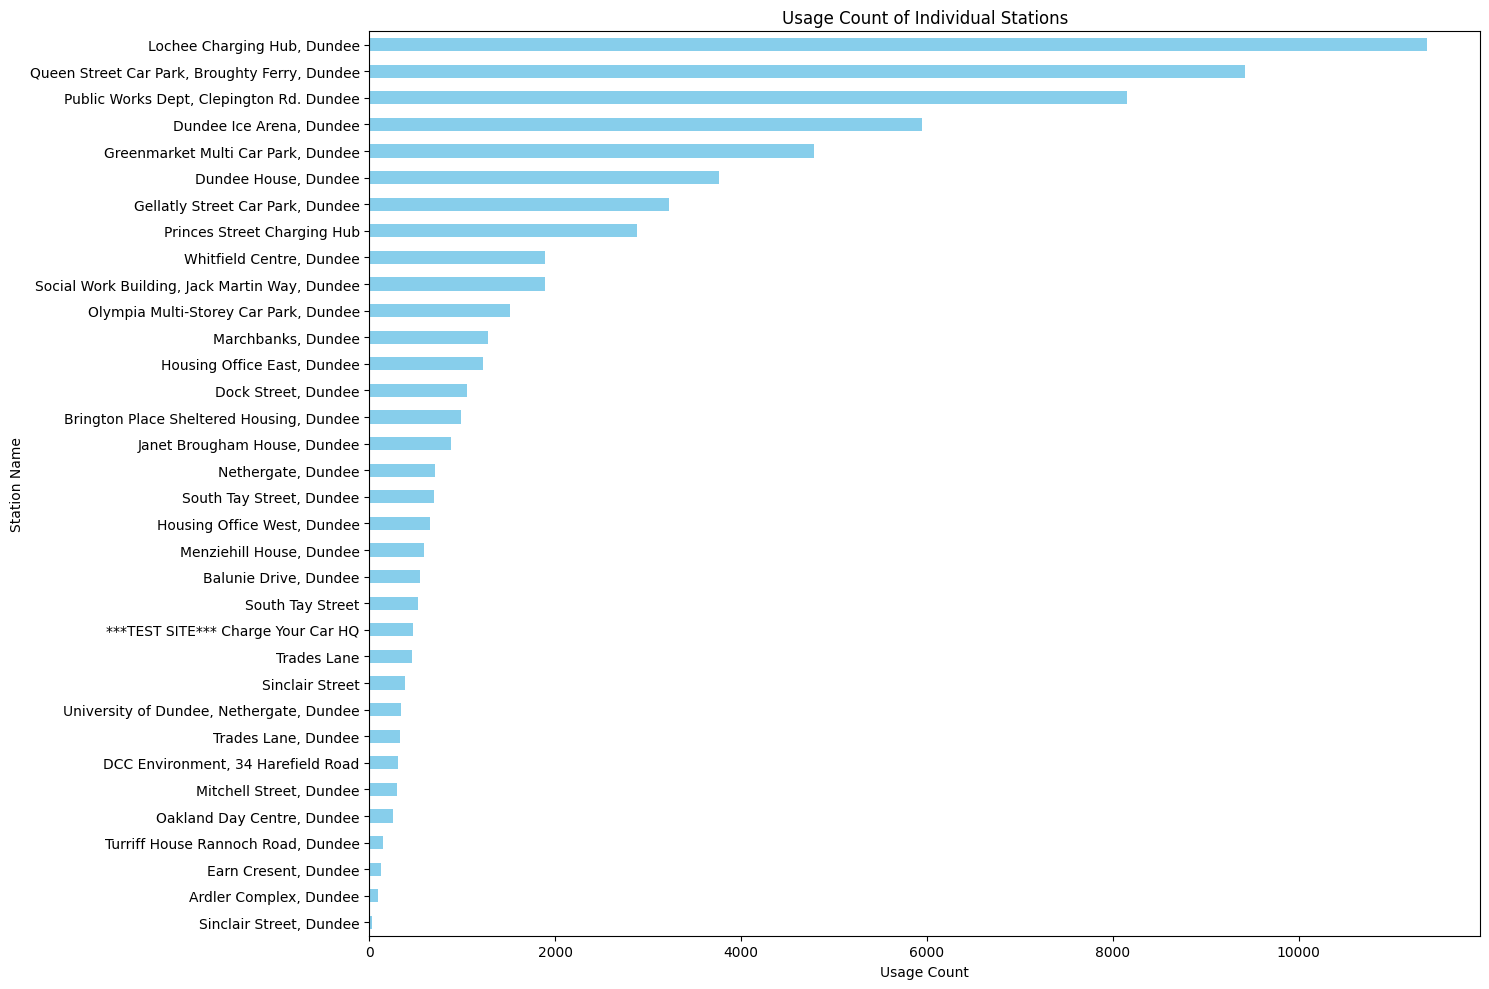

In [20]:
#occurrences of each unique station
station_counts = data['Address 1'].value_counts()
plt.figure(figsize=(15, 10))  
station_counts.plot(kind='barh', color='skyblue')  
plt.title('Usage Count of Individual Stations')
plt.xlabel('Usage Count')
plt.ylabel('Station Name')
plt.gca().invert_yaxis()  
plt.tight_layout()  
plt.show()

It is visible that some stations are duplicated (i.e 'Trades Lane, Dundee' and 'Trades Lane'). The next step is then to remove the duplicate stations, together with stations with no observations, or close to 0.

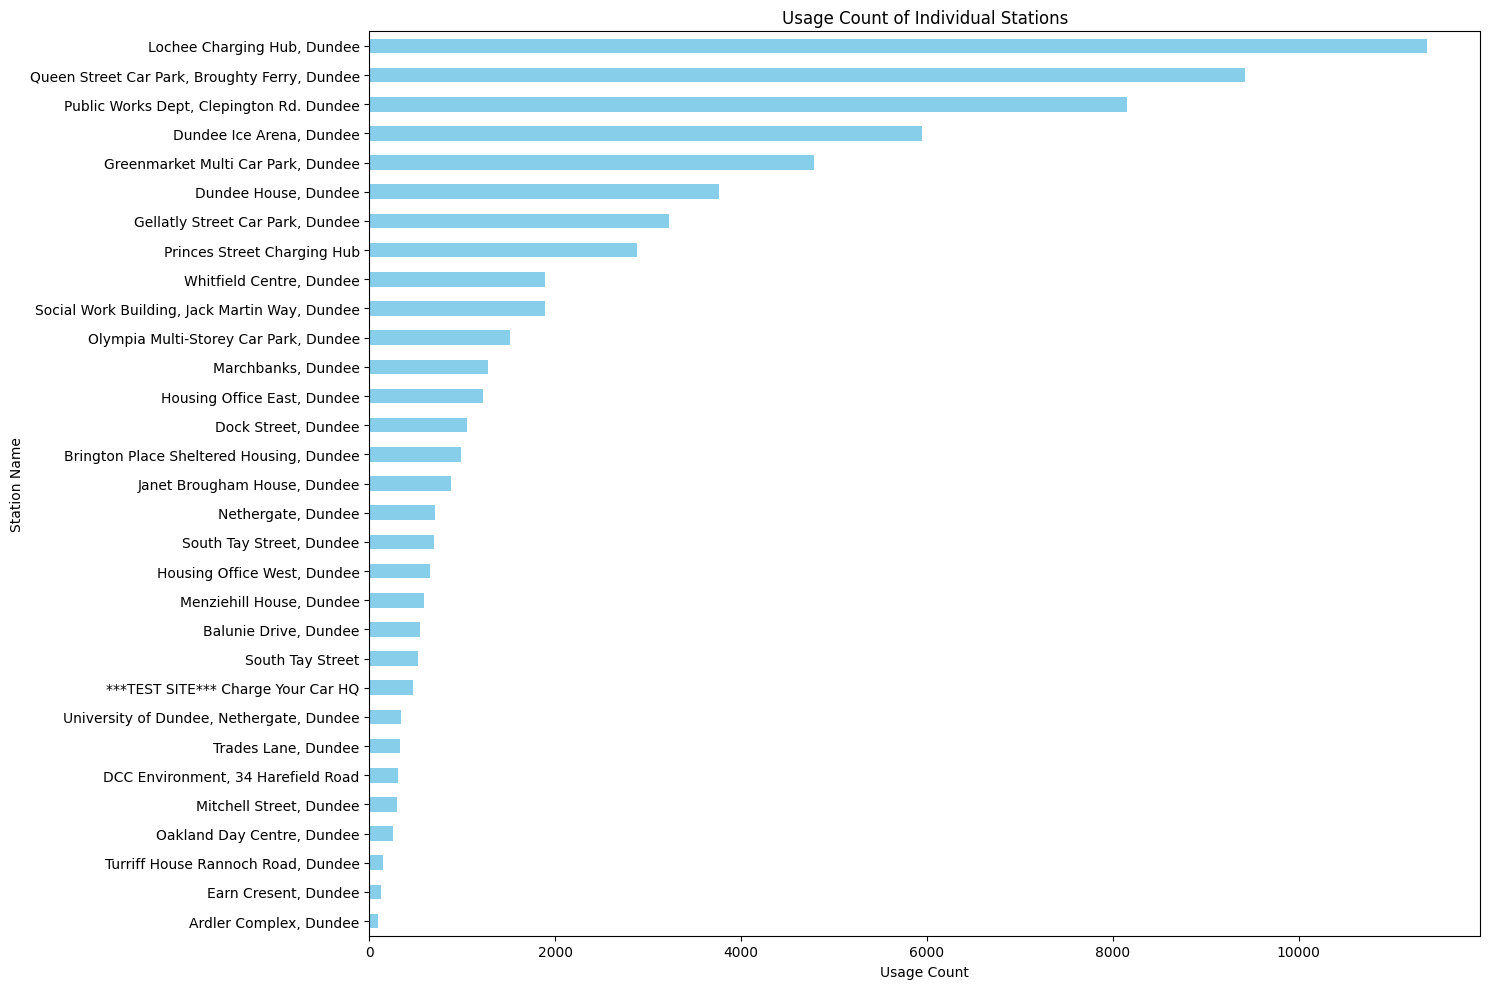

In [21]:
# Filter out 'Trades Lane' and 'Sinclair Street' from the 'Address 1' column
data_filtered = data[~data['Address 1'].isin(['Trades Lane', 'Sinclair Street','Sinclair Street, Dundee'])]

# Get the occurrences of each unique station, now excluding the specified addresses
station_counts = data_filtered['Address 1'].value_counts()

# Plot the usage count of the remaining individual stations
plt.figure(figsize=(15, 10))
station_counts.plot(kind='barh', color='skyblue')
plt.title('Usage Count of Individual Stations')
plt.xlabel('Usage Count')
plt.ylabel('Station Name')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 4.2 Model Implementation

As in previous section, the forecasting be implemented for the following time windows:
- 1 day
- 7 days
- 30 days

For 7 days time frame, we will reorganize the observations structure, so that sum the of the energy demand of 7 days will be one observation. Similarly, sum the of the energy demand of 30 days will be considered as one observation for 30 days time frame. For 1 and 7 day time frame, 30 lags are created, and for 30 day time frame we'll initialize 7 lags. 

**Daily predictions**

RMSE for Lochee Charging Hub, Dundee Stations: 125.73072340697016
RMSE for Greenmarket Multi Car Park, Dundee Stations: 42.19628773967832
RMSE for Queen Street Car Park, Broughty Ferry, Dundee Stations: 49.32355978285664
RMSE for Housing Office West, Dundee Stations: 9.5416140165886
RMSE for Nethergate, Dundee Stations: 12.174629001506919
RMSE for Brington Place Sheltered Housing, Dundee Stations: 4.305888339084825
RMSE for Balunie Drive, Dundee Stations: 12.54449530985603
RMSE for Social Work Building, Jack Martin Way, Dundee Stations: 7.497888580533634
RMSE for Dundee Ice Arena, Dundee Stations: 51.6150230330534
RMSE for Mitchell Street, Dundee Stations: 5.743683789085189
RMSE for Oakland Day Centre, Dundee Stations: 7.98205992107718
RMSE for Dock Street, Dundee Stations: 21.703847361006453
RMSE for Whitfield Centre, Dundee Stations: 18.860589945067993
RMSE for Housing Office East, Dundee Stations: 17.06781096127053
RMSE for Gellatly Street Car Park, Dundee Stations: 23.5327536142923

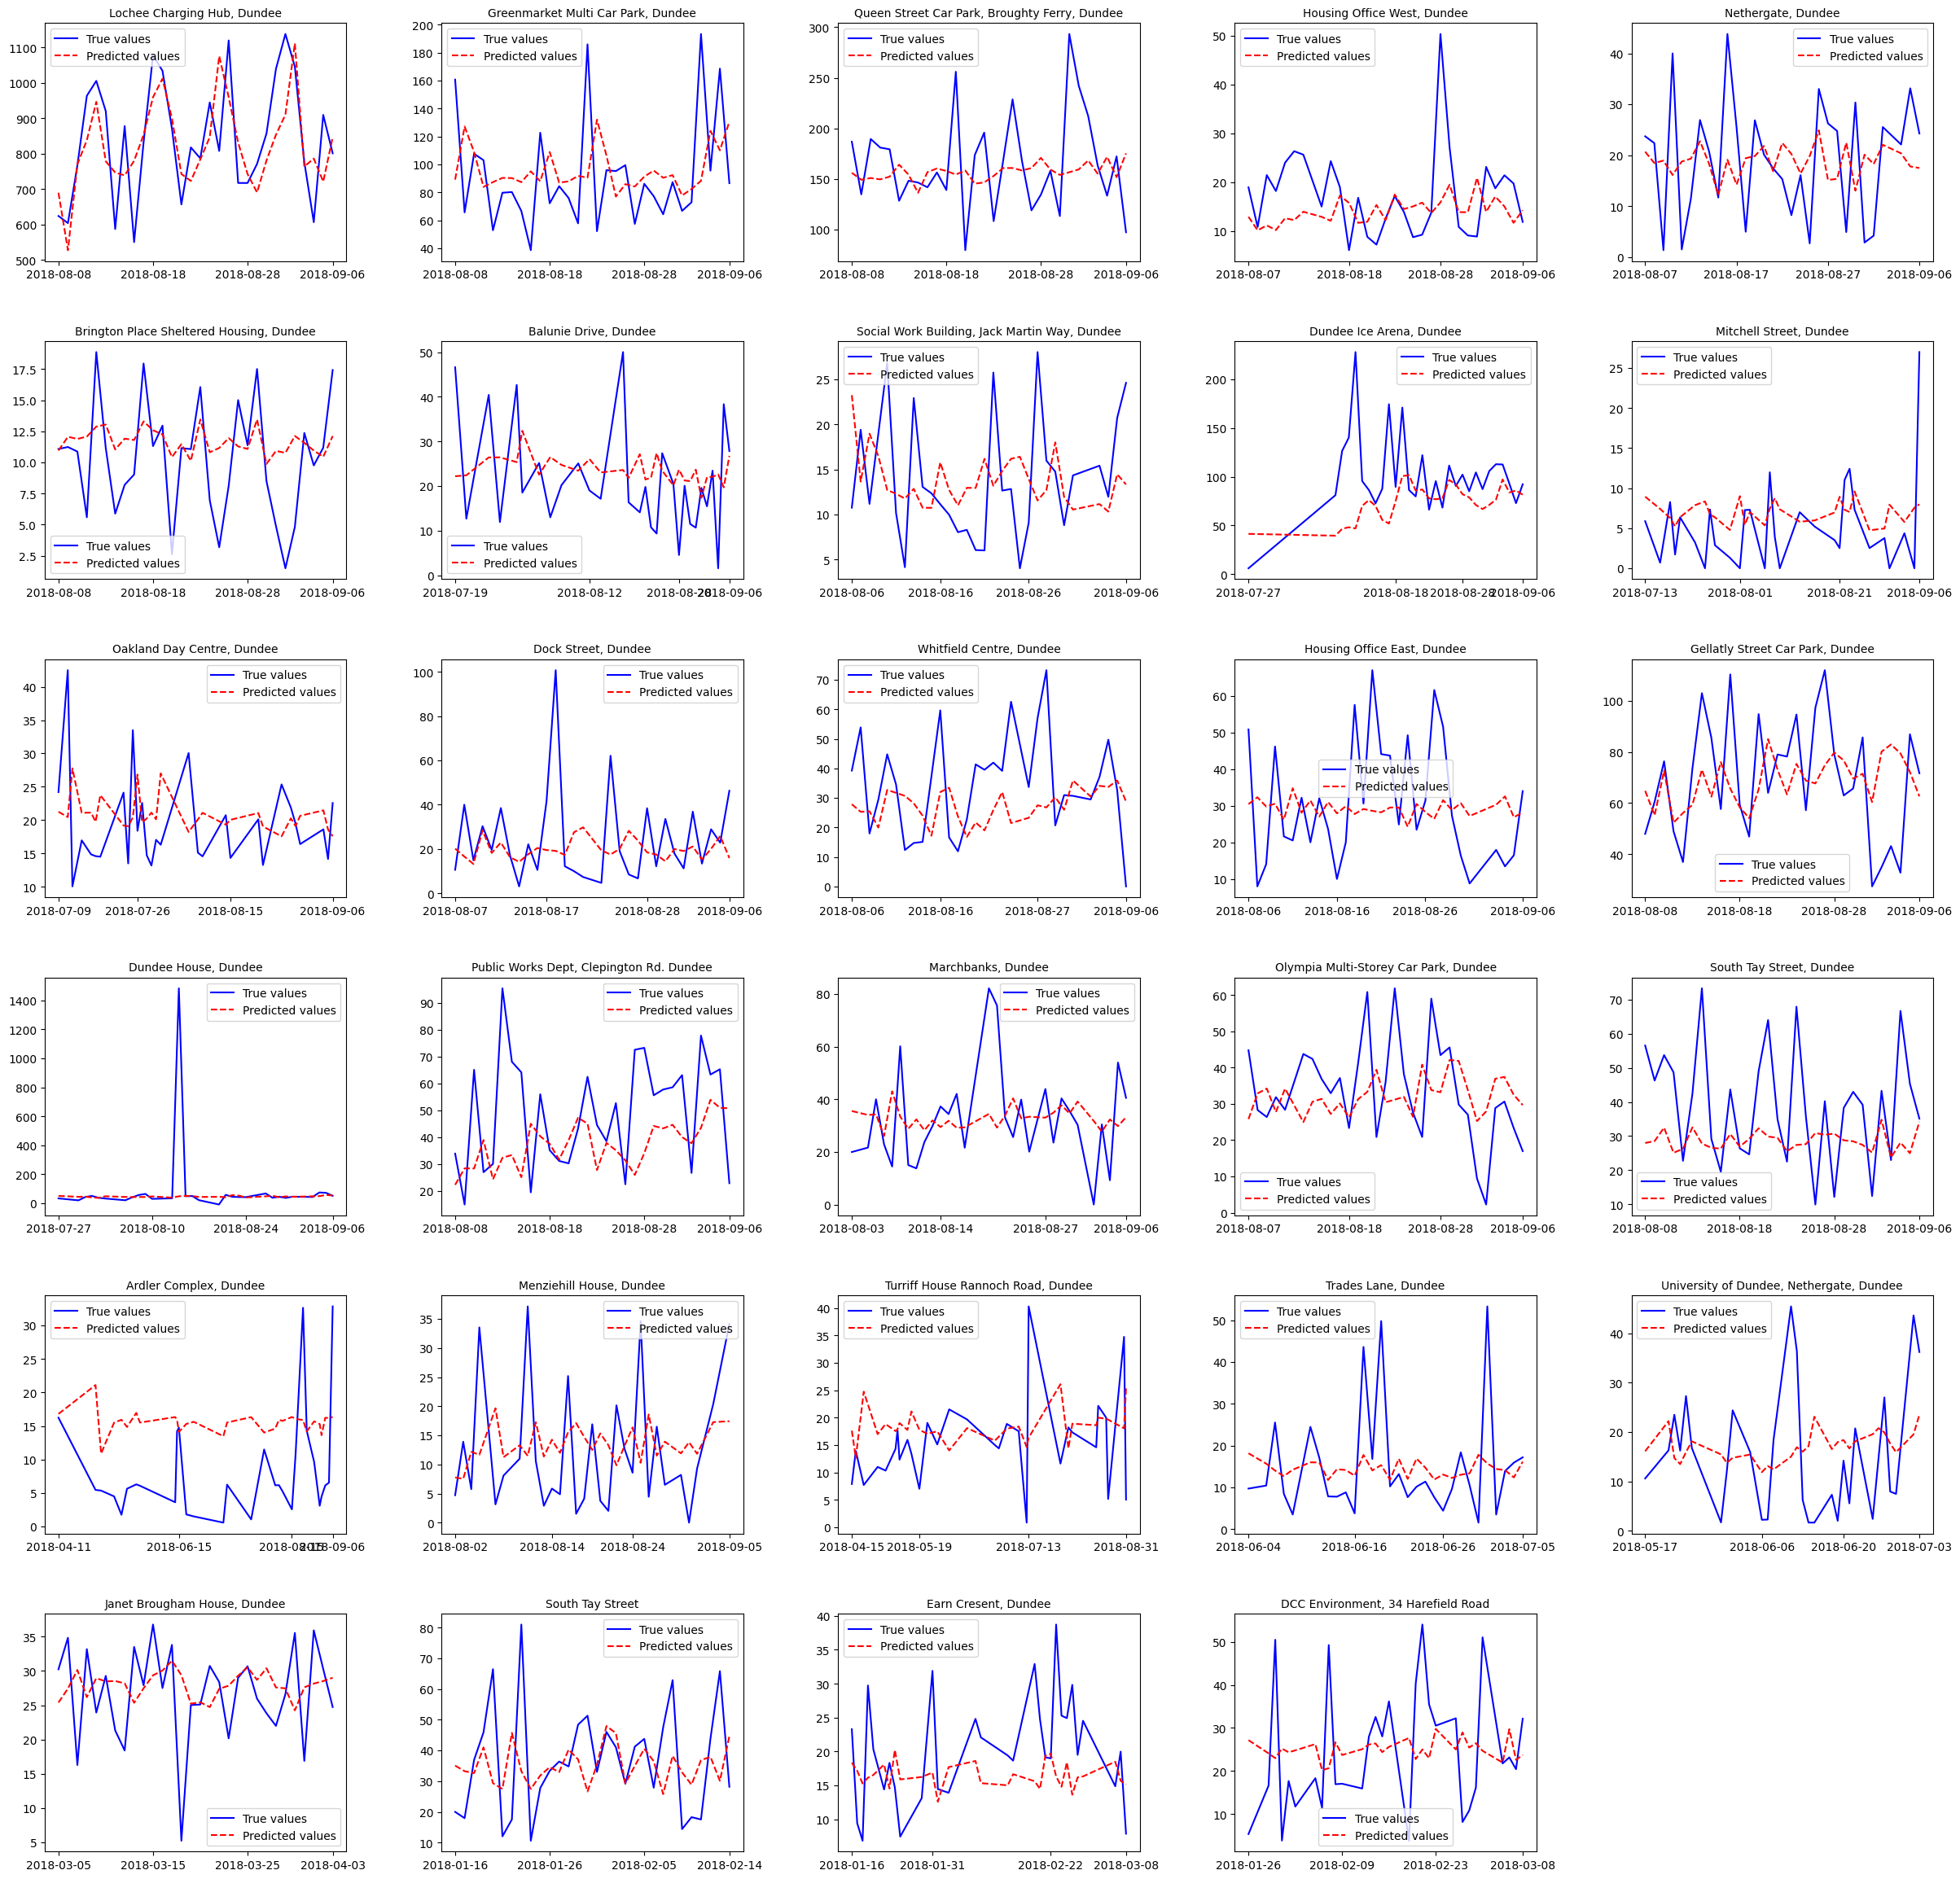

In [22]:
# Filter out specific stations
data_filtered = data[~data['Address 1'].isin(['Trades Lane', 'Sinclair Street', 'Sinclair Street, Dundee'])]

# Convert 'Start Date' to datetime
data_filtered['Start DateTime'] = pd.to_datetime(data_filtered['Start Date'], errors='coerce')
data_filtered.dropna(subset=['Start DateTime', 'Energy(kWh)'], inplace=True)

# Get unique stations after filtering
unique_stations = data_filtered['Address 1'].unique()

# Prepare to dynamically create subplots based on data availability
valid_data_stations = []  # To store stations with enough data

# Loop through each station and check data
for station in unique_stations:
    station_data = data_filtered[data_filtered['Address 1'] == station]
    daily_energy = station_data.groupby(station_data['Start DateTime'].dt.floor('D'))['Energy(kWh)'].sum()
    lagged_features = buildLaggedFeatures(daily_energy, lag=30)
    if lagged_features.shape[0] > 30:  # Ensuring enough data for split
        valid_data_stations.append(station)

# Number of plots
n_cols = 5
n_rows = (len(valid_data_stations) + n_cols - 1) // n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 4))  # Slightly increased size
axes = axes.flatten()


#Initialize empty dict
daily_predictions_dundee_rf={}
for station in stations:
    daily_predictions_dundee_rf[station]={'y_test':[], 'y_pred':[], 'rmse':0}
    
# Loop again to model and plot only where data is sufficient
for idx, station in enumerate(valid_data_stations):
    ax = axes[idx]
    station_data = data_filtered[data_filtered['Address 1'] == station]
    daily_energy = station_data.groupby(station_data['Start DateTime'].dt.floor('D'))['Energy(kWh)'].sum()
    lagged_features = buildLaggedFeatures(daily_energy, lag=30)
    train_data = lagged_features.iloc[:-30]
    test_data = lagged_features.iloc[-30:]

    X_train = train_data.drop(columns=['Energy(kWh)'])
    y_train = train_data['Energy(kWh)']
    X_test = test_data.drop(columns=['Energy(kWh)'])
    y_test = test_data['Energy(kWh)']

    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor.fit(X_train, y_train)
    y_pred = rf_regressor.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE for {station} Stations: {rmse}')
    # Set custom date ticks
    dates = y_test.index.tolist()
    ticks_to_use = [dates[0], dates[len(dates)//3], dates[2*len(dates)//3], dates[-1]]
    ax.set_xticks(ticks_to_use)

    ax.plot(y_test.index, y_test, color='blue', label='True values')
    ax.plot(y_test.index, y_pred, color='red', linestyle='--', label='Predicted values')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.set_title(station, fontsize=10)
    ax.legend()

    daily_predictions_dundee_rf[station]={'y_test':[y_test], 'y_pred':[y_pred], 'rmse':rmse}
# Hide any unused axes
for j in range(len(valid_data_stations), len(axes)):
    axes[j].axis('off')
    
file_path = 'daily_predictions_dundee_rf.pk1'
with open(file_path, 'wb') as file:
    pickle.dump(daily_predictions_dict, file)

fig.tight_layout(pad=4.0)  # Adjusted padding for clarity
plt.show()

**Weekly predictions**

RMSE for Greenmarket Multi Car Park, Dundee Stations: 142.54069305054463
RMSE for Queen Street Car Park, Broughty Ferry, Dundee Stations: 242.21859816834072
RMSE for Housing Office West, Dundee Stations: 39.49175394536726
RMSE for Nethergate, Dundee Stations: 48.258827172194216
RMSE for Brington Place Sheltered Housing, Dundee Stations: 14.145410162411585
RMSE for Balunie Drive, Dundee Stations: 17.893721954281702
RMSE for Social Work Building, Jack Martin Way, Dundee Stations: 45.99785817274197
RMSE for Dundee Ice Arena, Dundee Stations: 262.90024990774265
RMSE for Mitchell Street, Dundee Stations: 10.400481886981416
RMSE for Oakland Day Centre, Dundee Stations: 57.40725147496613
RMSE for Dock Street, Dundee Stations: 39.6598241732874
RMSE for Whitfield Centre, Dundee Stations: 81.6882361438467
RMSE for Housing Office East, Dundee Stations: 60.26858190368697
RMSE for Gellatly Street Car Park, Dundee Stations: 110.77352330603341
RMSE for Dundee House, Dundee Stations: 544.3056963631047

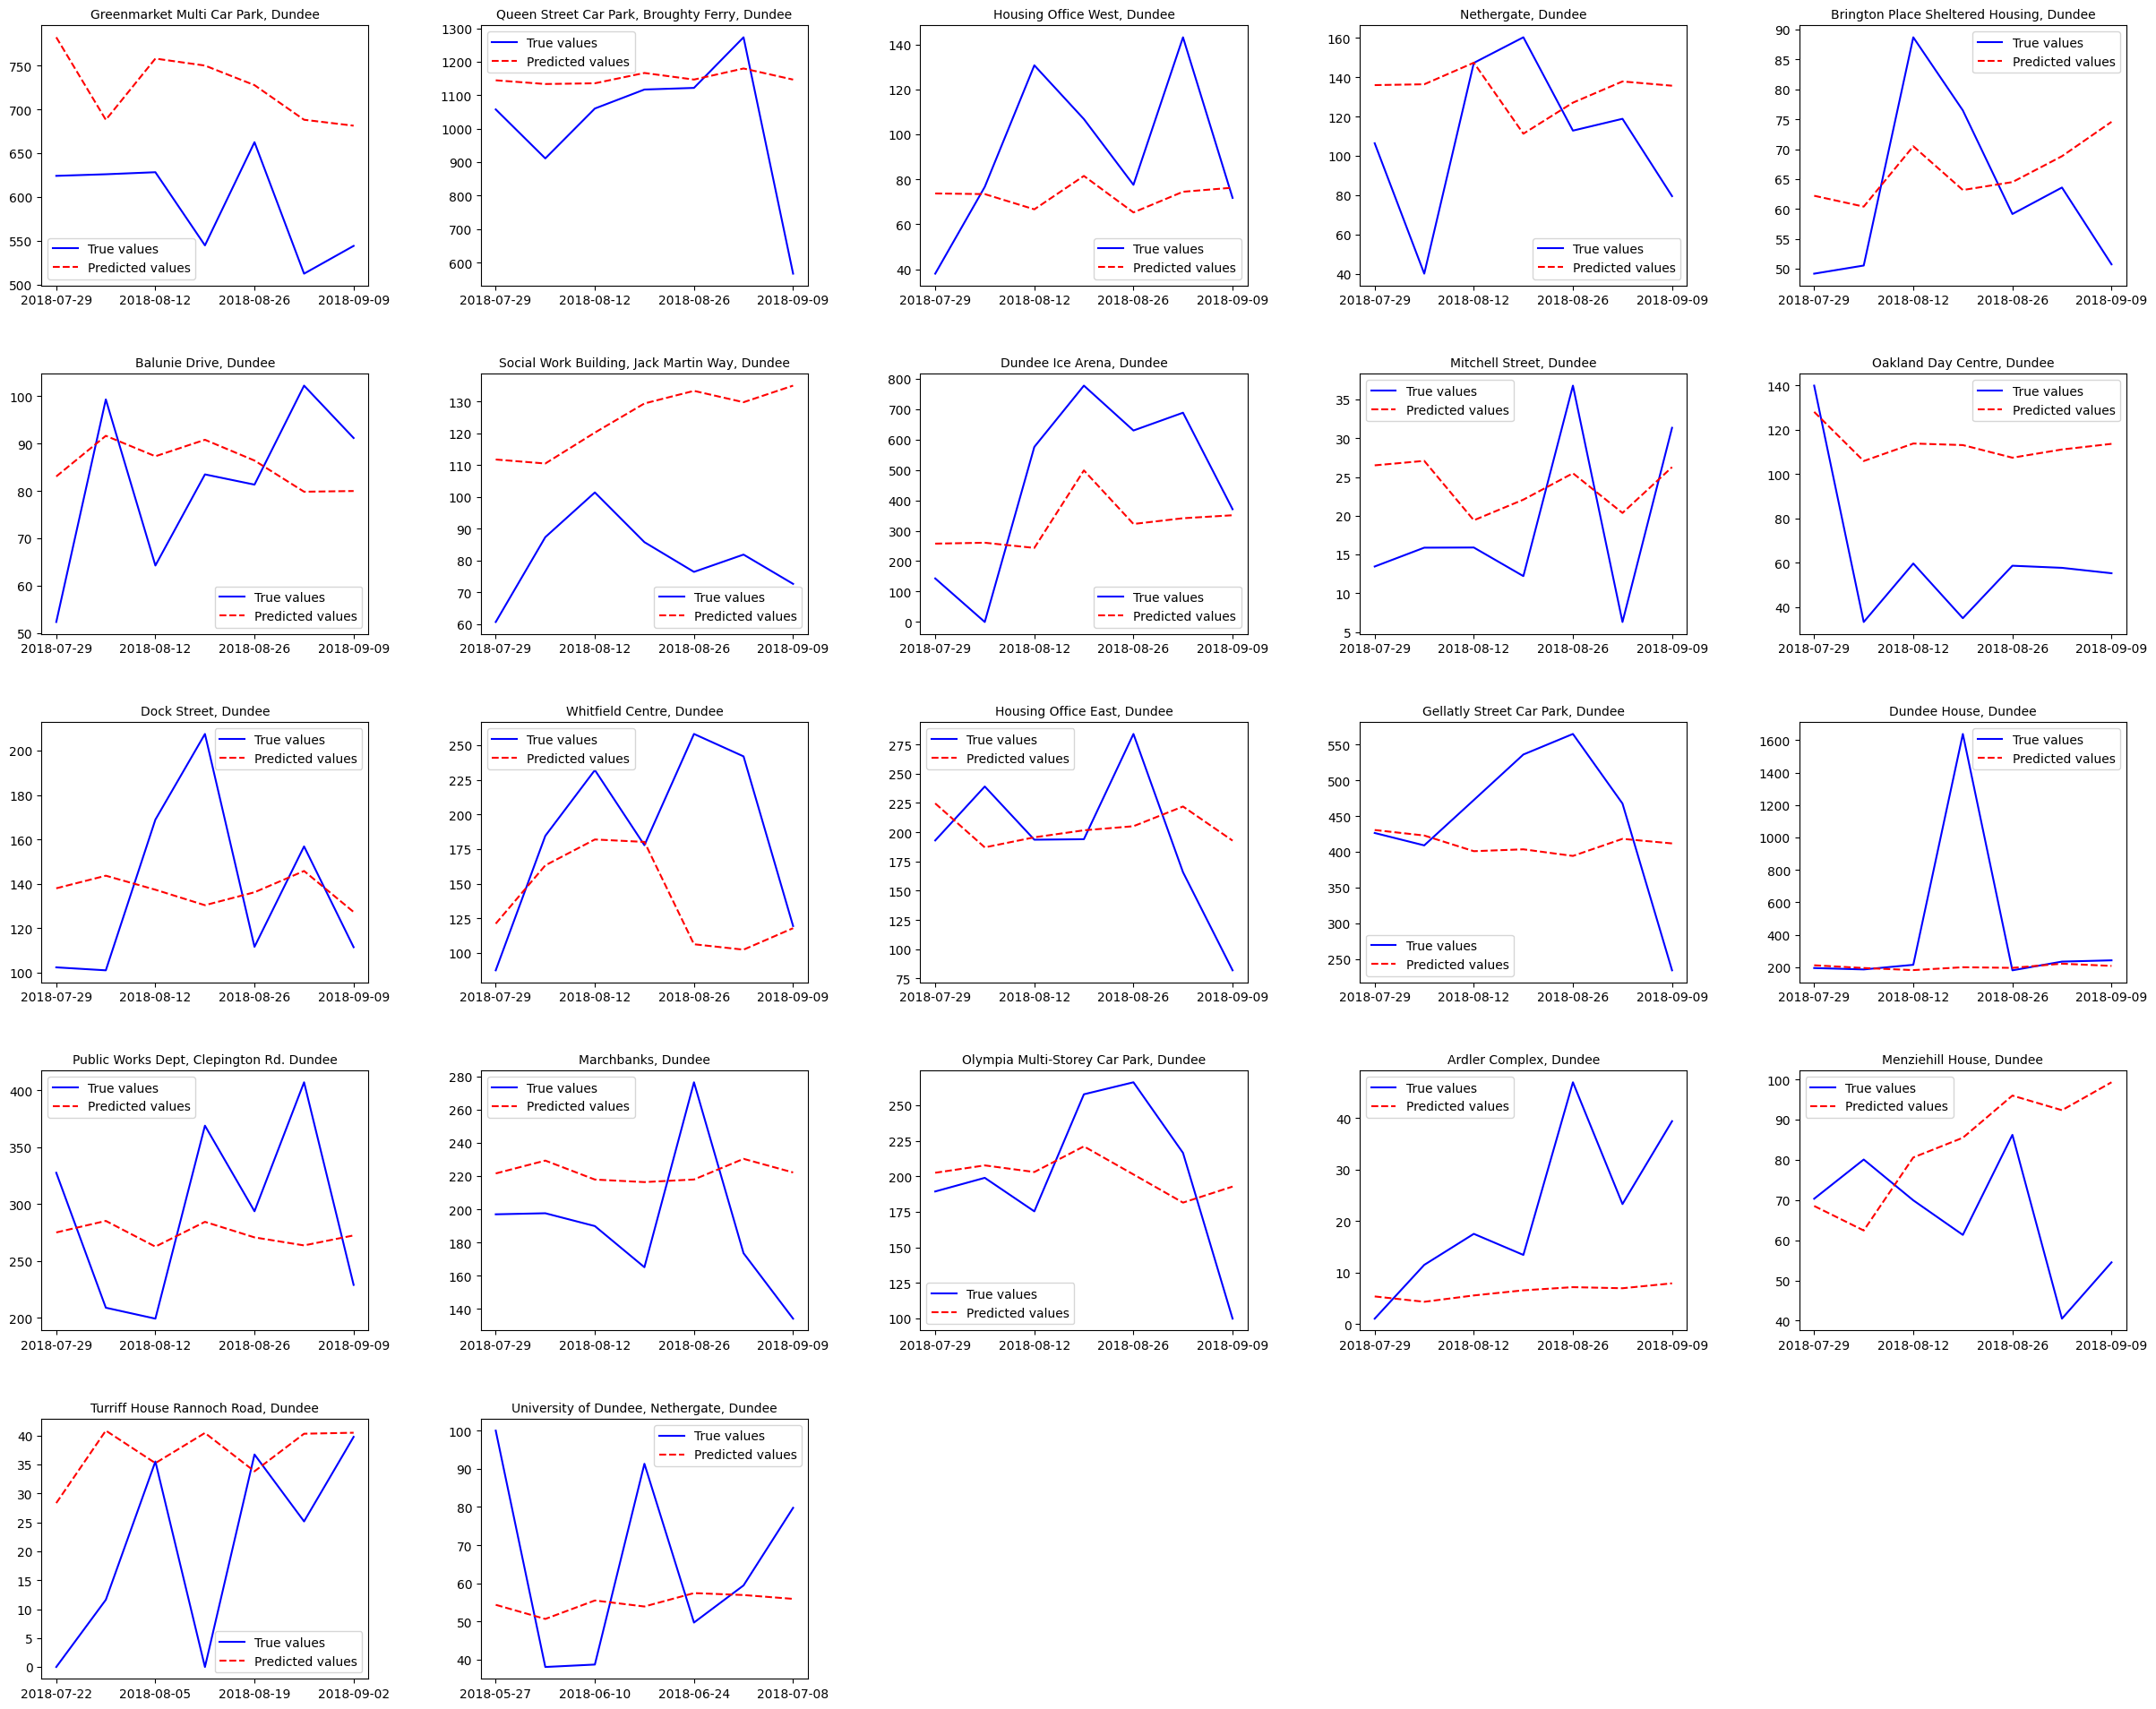

In [23]:
# Load data
data = pd.read_csv('Dundee_merged.csv')  # Ensure the path is correct

# Filter out specific stations
data_filtered = data[~data['Address 1'].isin(['Trades Lane', 'Sinclair Street', 'Sinclair Street, Dundee'])]

# Convert 'Start Date' to datetime
data_filtered['Start DateTime'] = pd.to_datetime(data_filtered['Start Date'], errors='coerce')
data_filtered.dropna(subset=['Start DateTime', 'Energy(kWh)'], inplace=True)

# Get unique stations after filtering
unique_stations = data_filtered['Address 1'].unique()

# Prepare to dynamically create subplots based on data availability
valid_data_stations = []  # To store stations with enough data

# Loop through each station and check data
for station in unique_stations:
    station_data = data_filtered[data_filtered['Address 1'] == station]
    weekly_energy = station_data.set_index('Start DateTime').resample('W')['Energy(kWh)'].sum().dropna()
    lagged_features = buildLaggedFeatures(weekly_energy, lag=30)
    if lagged_features.shape[0] > 7:  # Ensuring enough data for split
        valid_data_stations.append(station)

# Number of plots
n_cols = 5
n_rows = (len(valid_data_stations) + n_cols - 1) // n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 4))  # Slightly increased size
axes = axes.flatten()

#Initialize empty dict
weekly_predictions_dundee_rf={}
for station in stations:
   weekly_predictions_dundee_rf[station]={'y_test':[], 'y_pred':[], 'rmse':0}

# Loop again to model and plot only where data is sufficient
for idx, station in enumerate(valid_data_stations):
    ax = axes[idx]
    station_data = data_filtered[data_filtered['Address 1'] == station]
    weekly_energy = station_data.set_index('Start DateTime').resample('W')['Energy(kWh)'].sum().dropna()
    
    lagged_features = buildLaggedFeatures(weekly_energy, lag=30)
    train_data = lagged_features.iloc[:-7]
    test_data = lagged_features.iloc[-7:]

    X_train = train_data.drop(columns=['Energy(kWh)'])
    y_train = train_data['Energy(kWh)']
    X_test = test_data.drop(columns=['Energy(kWh)'])
    y_test = test_data['Energy(kWh)']

    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor.fit(X_train, y_train)
    y_pred = rf_regressor.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE for {station} Stations: {rmse}')
    # Set custom date ticks
    dates = y_test.index.tolist()
    ticks_to_use = [dates[0], dates[len(dates)//3], dates[2*len(dates)//3], dates[-1]]
    ax.set_xticks(ticks_to_use)

    ax.plot(y_test.index, y_test, color='blue', label='True values')
    ax.plot(y_test.index, y_pred, color='red', linestyle='--', label='Predicted values')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.set_title(station, fontsize=10)
    ax.legend()
    
    weekly_predictions_dundee_rf[station]={'y_test':[y_test], 'y_pred':[y_pred], 'rmse':rmse}

# Hide any unused axes
for j in range(len(valid_data_stations), len(axes)):
    axes[j].axis('off')
    
file_path = 'weekly_predictions_dundee_rf.pk1'
with open(file_path, 'wb') as file:
    pickle.dump(daily_predictions_dict, file)

fig.tight_layout(pad=4.0)  # Adjusted padding for clarity
plt.show()

**Monthly predictions**

RMSE for Greenmarket Multi Car Park, Dundee Stations: 2335.2718040351665
RMSE for Queen Street Car Park, Broughty Ferry, Dundee Stations: 2399.1106654477326
RMSE for Housing Office West, Dundee Stations: 167.84203635343167
RMSE for Nethergate, Dundee Stations: 257.6565977557016
RMSE for Brington Place Sheltered Housing, Dundee Stations: 200.18845822412806
RMSE for Balunie Drive, Dundee Stations: 124.00274290235159
RMSE for Social Work Building, Jack Martin Way, Dundee Stations: 274.6412705155221
RMSE for Dundee Ice Arena, Dundee Stations: 1469.9472229935698
RMSE for Mitchell Street, Dundee Stations: 66.72479279435797
RMSE for Oakland Day Centre, Dundee Stations: 372.8770220774586
RMSE for Dock Street, Dundee Stations: 250.70065890683782
RMSE for Whitfield Centre, Dundee Stations: 375.3260047240438
RMSE for Housing Office East, Dundee Stations: 437.5394178327441
RMSE for Gellatly Street Car Park, Dundee Stations: 945.2640504945048
RMSE for Dundee House, Dundee Stations: 955.699386161178

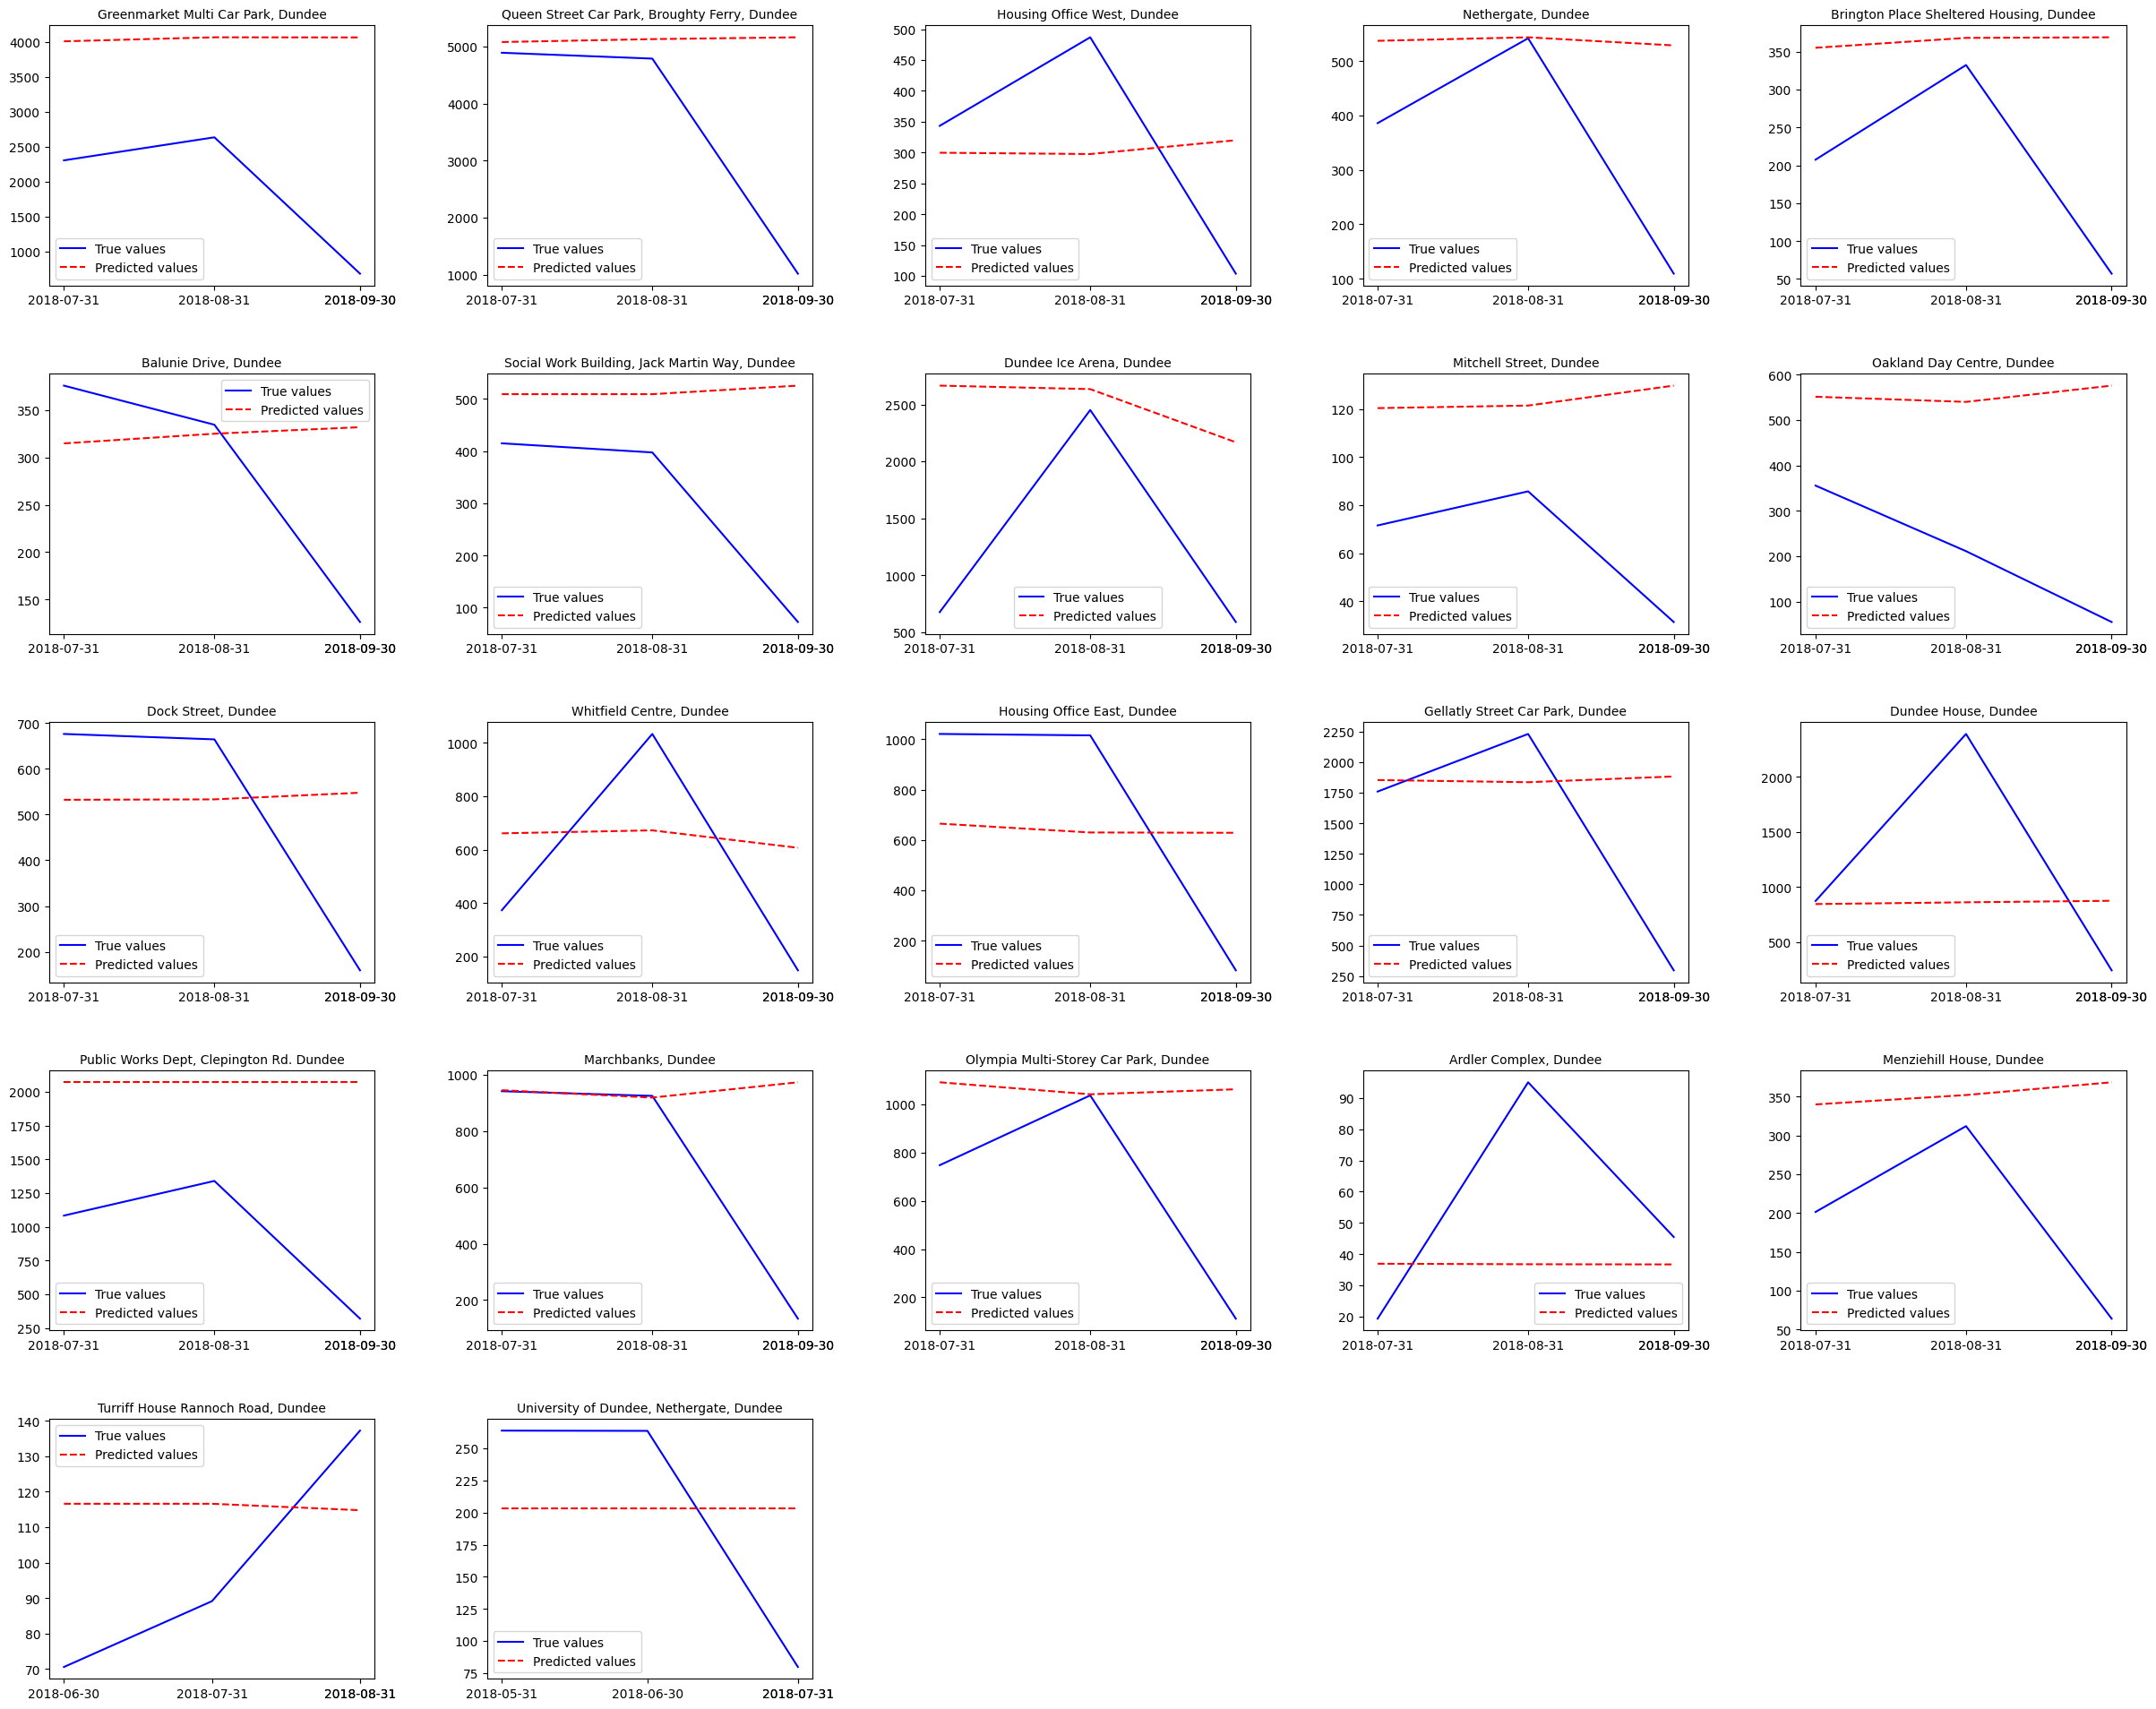

In [24]:
# Load data
data = pd.read_csv('Dundee_merged.csv')  # Ensure the path is correct

# Filter out specific stations
data_filtered = data[~data['Address 1'].isin(['Trades Lane', 'Sinclair Street', 'Sinclair Street, Dundee'])]

# Convert 'Start Date' to datetime
data_filtered['Start DateTime'] = pd.to_datetime(data_filtered['Start Date'], errors='coerce')
data_filtered.dropna(subset=['Start DateTime', 'Energy(kWh)'], inplace=True)

# Get unique stations after filtering
unique_stations = data_filtered['Address 1'].unique()

# Prepare to dynamically create subplots based on data availability
valid_data_stations = []  # To store stations with enough data

# Loop through each station and check data
for station in unique_stations:
    station_data = data_filtered[data_filtered['Address 1'] == station]
    monthly_energy = station_data.set_index('Start DateTime').resample('M')['Energy(kWh)'].sum().dropna()
    lagged_features = buildLaggedFeatures(monthly_energy, lag=7)
    if lagged_features.shape[0] > 3:  # Ensuring enough data for split
        valid_data_stations.append(station)

# Number of plots
n_cols = 5
n_rows = (len(valid_data_stations) + n_cols - 1) // n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 4))  # Slightly increased size
axes = axes.flatten()

#Initialize empty dict
monthly_predictions_dundee_rf={}
for station in stations:
    monthly_predictions_dundee_rf[station]={'y_test':[], 'y_pred':[], 'rmse':0}

# Loop again to model and plot only where data is sufficient
for idx, station in enumerate(valid_data_stations):
    ax = axes[idx]
    station_data = data_filtered[data_filtered['Address 1'] == station]
    monthly_energy = station_data.set_index('Start DateTime').resample('M')['Energy(kWh)'].sum().dropna()
    lagged_features = buildLaggedFeatures(monthly_energy, lag=7)
    train_data = lagged_features.iloc[:-3]
    test_data = lagged_features.iloc[-3:]

    X_train = train_data.drop(columns=['Energy(kWh)'])
    y_train = train_data['Energy(kWh)']
    X_test = test_data.drop(columns=['Energy(kWh)'])
    y_test = test_data['Energy(kWh)']

    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor.fit(X_train, y_train)
    y_pred = rf_regressor.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE for {station} Stations: {rmse}')
    # Set custom date ticks
    dates = y_test.index.tolist()
    ticks_to_use = [dates[0], dates[len(dates)//3], dates[2*len(dates)//3], dates[-1]]
    ax.set_xticks(ticks_to_use)

    ax.plot(y_test.index, y_test, color='blue', label='True values')
    ax.plot(y_test.index, y_pred, color='red', linestyle='--', label='Predicted values')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.set_title(station, fontsize=10)
    ax.legend()
    
    monthly_predictions_dundee_rf[station]={'y_test':[y_test], 'y_pred':[y_pred], 'rmse':rmse}

# Hide any unused axes
for j in range(len(valid_data_stations), len(axes)):
    axes[j].axis('off')

file_path = 'monthly_predictions_dundee_rf.pk1'
with open(file_path, 'wb') as file:
    pickle.dump(daily_predictions_dict, file)

fig.tight_layout(pad=4.0)  # Adjusted padding for clarity
plt.show()

## 5. Random Forest Forecasting for Perth

In [25]:
df_1 = pd.read_csv('EV_ChargeStation_Use_Sept_2016_to_Aug_2017.csv', index_col=[0]).drop(columns=['OBJECTID'])
df_2 = pd.read_csv('EVChargeStationUseSept2017toAug2018.csv', index_col=[0])
df_3 = pd.read_csv('EVChargeStationUseSept2018toAug2019.csv', index_col=[0])

FileNotFoundError: [Errno 2] No such file or directory: 'EV_ChargeStation_Use_Sept_2016_to_Aug_2017.csv'

After loading the new data, the first step is to get overfiew of different stations, and more importantly do they have enough observations for conducting a forecast. Additionally, the three datasets will be merged into one for easier analysis.

### 5.1 Basic Stats

In [ ]:
df_1 = df_1[df_1['Site'] != '***TEST SITE*** Charge Your Car HQ']
df_3 = df_3[df_3['Site'] != '***TEST SITE*** Charge Your Car HQ']

# Define a mapping dictionary for renaming
rename_mapping = {
    'King Street Car Park, Crieff': 'King Street Car Park',
    'Broxden Park & Ride, Perth': 'Broxden Park & Ride',
    'Canal Street Car Park 3rd floor, Perth': 'Canal Street Car Park',
    'Canal Street Car Park 3rd floor ': 'Canal Street Car Park',
    'Friarton Depot, Perth': 'Friarton Depot',
    'South Inch Car Park, Perth': 'South Inch Car Park',
    'Kinross Park and Ride, Kinross': 'Kinross Park and Ride',
    ' Leslie Street Car Park, Blairgowrie': 'Leslie Street Car Park, Blairgowrie',
}

# Replace the values in the 'Site' column using the mapping
df_1['Site'] = df_1['Site'].replace(rename_mapping)
df_2['Site'] = df_2['Site'].replace(rename_mapping)
df_3['Site'] = df_3['Site'].replace(rename_mapping)

df_1 = df_1.rename(columns={
    'CP_ID': 'CP ID',
    'Start_Date': 'Start Date',
    'Start_Time': 'Start Time',
    'End_Date': 'End Date',
    'End_Time': 'End Time',
    'Total_kWh': 'Total kWh'
})

# Dates
df_1['Date'] = pd.to_datetime(df_1['Start Date'].str[:10], errors='coerce')
df_2['Date'] = pd.to_datetime(df_2['Start Date'].str[:10], errors='coerce')
df_3['Date'] = pd.to_datetime(df_3['Start Date'].str[:10], errors='coerce')

# Union data
data = pd.concat([df_1, df_2, df_3]).drop_duplicates()

# Drop records with below 0 Total kWh
data = data[data['Total kWh'] >= 0]

# Drop two stations (too little data)
df = data[data['Site'] != 'Market Square Alyth']
df = data[data['Site'] != 'Mill Street, Perth']

After removing duplicate stations and stations with no observations, the stations, which have also been reset with mapping dictionary are displayed in the next plot.

In [ ]:
#occurrences of each unique station
station_counts = data['Site'].value_counts()
plt.figure(figsize=(15, 10))  
station_counts.plot(kind='barh', color='skyblue')  
plt.title('Usage Count of Individual Stations')
plt.xlabel('Usage Count')
plt.ylabel('Station Name')
plt.gca().invert_yaxis()  
plt.tight_layout()  
plt.show()

### 5.2 Model Implementation

As for the previous datasets, the forecasting be implemented for the following time windows:
- 1 day
- 7 days
- 30 days

For 7 days time frame, we will reorganize the observations structure, so that sum the of the energy demand of 7 days will be one observation. Similarly, sum the of the energy demand of 30 days will be considered as one observation for 30 days time frame. For 1 and 7 day time frame, 30 lags are created, and for 30 day time frame we'll initialize 7 lags. 

**Daily predictions**

In [ ]:
# Convert 'Start Date' to datetime, assuming 'Start Date' is the column name
data['Start DateTime'] = pd.to_datetime(data['Start Date'], errors='coerce')
data.dropna(subset=['Start DateTime', 'Total kWh'], inplace=True)

# Get unique stations after filtering
unique_stations = data['Site'].unique()


# Number of plots
n_cols = 5
n_rows = (len(unique_stations) + n_cols - 1) // n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

used_axes = 0  # Track the number of axes actually used
#Initialize empty dict
daily_predictions_perth_rf={}
for station in stations:
    daily_predictions_perth_rf[station]={'y_test':[], 'y_pred':[], 'rmse':0}
    
# Loop through each station and plot
for station in unique_stations:
    station_data = data[data['Site'] == station]
    daily_energy = station_data.groupby(station_data['Start DateTime'].dt.floor('D'))['Total kWh'].sum()
    lagged_features = buildLaggedFeatures(daily_energy, lag=30)

    if len(lagged_features) > 30:
        ax = axes[used_axes]
        used_axes += 1
        train_data = lagged_features.iloc[:-30]
        test_data = lagged_features.iloc[-30:]

        X_train = train_data.drop('Total kWh', axis=1)
        y_train = train_data['Total kWh']
        X_test = test_data.drop('Total kWh', axis=1)
        y_test = test_data['Total kWh']

        rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_regressor.fit(X_train, y_train)
        y_pred = rf_regressor.predict(X_test)

        ax.plot(y_test.index, y_test, color='blue', label='True values')
        ax.plot(y_test.index, y_pred, color='red', linestyle='--', label='Predicted values')

        rmse = sqrt(mean_squared_error(y_test, y_pred))
        print(f'RMSE for {station} Stations: {rmse}')
        
        # Define the custom x-axis ticks
        if len(y_test.index) >= 3:
            ticks_to_use = [y_test.index[0], y_test.index[len(y_test.index) // 2], y_test.index[-1]]
        else:
            ticks_to_use = y_test.index
        ax.set_xticks(ticks_to_use)
        ax.set_xticklabels([label.strftime('%Y-%m-%d') for label in ticks_to_use], rotation=45)
        ax.set_title(station, fontsize=10)
        ax.legend()
        
        daily_predictions_perth_rf[station]={'y_test':[y_test], 'y_pred':[y_pred], 'rmse':rmse}

# Hide any unused axes if there are less than planned
for j in range(used_axes, len(axes)):
    axes[j].axis('off')
    
file_path = 'daily_predictions_perth_rf.pk1'
with open(file_path, 'wb') as file:
    pickle.dump(daily_predictions_dict, file)

fig.tight_layout(pad=4.0)  # Adjusted padding for clarity
plt.show()

**Weekly predictions**

In [ ]:
data['Start DateTime'] = pd.to_datetime(data['Start Date'], errors='coerce')
data.dropna(subset=['Start DateTime', 'Total kWh'], inplace=True)
# Get unique stations after filtering
unique_stations = data['Site'].unique()

# Number of plots
n_cols = 5
n_rows = (len(unique_stations) + n_cols - 1) // n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

#Initialize empty dict
weekly_predictions_perth_rf={}
for station in stations:
    weekly_predictions_perth_rf[station]={'y_test':[], 'y_pred':[], 'rmse':0}

# Loop through each station and plot
for idx, station in enumerate(unique_stations):
    ax = axes[idx]
    station_data = data[data['Site'] == station]
    weekly_energy = station_data.set_index('Start DateTime').resample('W')['Total kWh'].sum().dropna()
    lagged_features = buildLaggedFeatures(weekly_energy, lag=30)

    if len(lagged_features) > 7:
        train_data = lagged_features.iloc[:-7]
        test_data = lagged_features.iloc[-7:]

        X_train = train_data.drop('Total kWh', axis=1)
        y_train = train_data['Total kWh']
        X_test = test_data.drop('Total kWh', axis=1)
        y_test = test_data['Total kWh']

        rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_regressor.fit(X_train, y_train)
        y_pred = rf_regressor.predict(X_test)

        ax.plot(y_test.index, y_test, color='blue', label='True values')
        ax.plot(y_test.index, y_pred, color='red', linestyle='--', label='Predicted values')
        
        weekly_predictions_perth_rf[station]={'y_test':[y_test], 'y_pred':[y_pred], 'rmse':rmse}

        # Define the custom x-axis ticks
        if len(y_test.index) >= 3:
            ticks_to_use = [y_test.index[0], y_test.index[len(y_test.index) // 2], y_test.index[-1]]
        else:
            ticks_to_use = y_test.index
        ax.set_xticks(ticks_to_use)
        ax.set_xticklabels([label.strftime('%Y-%m-%d') for label in ticks_to_use])

        # RMSE
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        print(f'RMSE for {station} Stations: {rmse}')

    else:
        # Display message if not enough data but keep the plot clean
        ax.text(0.5, 0.5, 'Not enough data', horizontalalignment='center', verticalalignment='center', fontsize=12, transform=ax.transAxes)
    
    ax.set_title(station, fontsize=10)
    ax.legend()

# Hide any unused axes if there are less than planned
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')
    
file_path = 'weekly_predictions_perth_rf.pk1'
with open(file_path, 'wb') as file:
    pickle.dump(daily_predictions_dict, file)

fig.tight_layout(pad=4.0)  # Adjusted padding for clarity
plt.show()

**Monthly predictions**

In [ ]:
# Convert 'Start Date' to datetime, assuming 'Start Date' is the column name
data['Start DateTime'] = pd.to_datetime(data['Start Date'], errors='coerce')
data.dropna(subset=['Start DateTime', 'Total kWh'], inplace=True)
# Get unique stations after filtering
unique_stations = data['Site'].unique()

# Number of plots
n_cols = 5
n_rows = (len(unique_stations) + n_cols - 1) // n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

#Initialize empty dict
monthly_predictions_perth_rf={}
for station in stations:
    monthly_predictions_perth_rf[station]={'y_test':[], 'y_pred':[], 'rmse':0}

# Loop through each station and plot
for idx, station in enumerate(unique_stations):
    ax = axes[idx]
    station_data = data[data['Site'] == station]
    monthly_energy = station_data.set_index('Start DateTime').resample('M')['Total kWh'].sum().dropna()
    lagged_features = buildLaggedFeatures(monthly_energy, lag=7)

    if len(lagged_features) > 4:
        train_data = lagged_features.iloc[:-3]
        test_data = lagged_features.iloc[-3:]

        X_train = train_data.drop('Total kWh', axis=1)
        y_train = train_data['Total kWh']
        X_test = test_data.drop('Total kWh', axis=1)
        y_test = test_data['Total kWh']

        rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_regressor.fit(X_train, y_train)
        y_pred = rf_regressor.predict(X_test)

        ax.plot(y_test.index, y_test, color='blue', label='True values')
        ax.plot(y_test.index, y_pred, color='red', linestyle='--', label='Predicted values')

        # Define the custom x-axis ticks
        if len(y_test.index) >= 3:
            ticks_to_use = [y_test.index[0], y_test.index[len(y_test.index) // 2], y_test.index[-1]]
        else:
            ticks_to_use = y_test.index
        ax.set_xticks(ticks_to_use)
        ax.set_xticklabels([label.strftime('%Y-%m-%d') for label in ticks_to_use])

        # RMSE
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        print(f'RMSE for {station} Stations: {rmse}')

    else:
        # Display message if not enough data but keep the plot clean
        ax.text(0.5, 0.5, 'Not enough data', horizontalalignment='center', verticalalignment='center', fontsize=12, transform=ax.transAxes)
    
    ax.set_title(station, fontsize=10)
    ax.legend()
    
    monthly_predictions_perth_rf[station]={'y_test':[y_test], 'y_pred':[y_pred], 'rmse':rmse}


# Hide any unused axes if there are less than planned
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')
file_path = 'monthly_predictions_perth_rf.pk1'
with open(file_path, 'wb') as file:
    pickle.dump(daily_predictions_dict, file)
    
fig.tight_layout(pad=4.0)  # Adjusted padding for clarity
plt.show()

## 6. Conclusion

The Random Forest model displayed the best performance on the Palo Alto, followed by Perth. That is mostly due to the lack of quality of Dundee dataset. Too many missing values biased the time series of energy demand and the model was unable to produce decent forecasts for those datasets. However, it is questionable which dataset is better, as Palo Alto has only 7 stations, while Dundee contains much more, but with fewer observations. If the Palo Alto dataset had more stations with more observations, the model might live up to the task.